In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [2]:
# Import dataframe column names and helper functions
%run -i columns.py
%run -i helper_functions.py

In [3]:
# Load the dataset containing the happiness and urbanization data of developing countries
df = pd.read_csv('tmp/developing_countries.csv')

In [4]:
# Use the mean imputation method to impute missing values in the developing countries dataset
threshold = 0.6
df_thresh = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
df_impute = df_thresh.fillna(df_thresh.mean())
df_impute.describe()

/tmp/ipykernel_18794/1194375895.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_impute = df_thresh.fillna(df_thresh.mean())


,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Air transport, passengers carried","Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Urban population (% of total)
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,4.570000e+02,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,2016.494530,92.221007,5.022313,0.795687,0.974366,0.512896,0.389140,0.104963,0.214298,2.030955,2.076123e+04,1.814317e+07,13.890841,31.216241,19.793201,48.990571,42.805461,23036.702831,12.666669,55.169177
std,1.118266,39.978960,0.968432,0.365876,0.323990,0.213048,0.150710,0.082750,0.120375,0.585681,1.515434e+05,4.409611e+07,9.118862,21.638516,8.503950,15.875213,21.451886,25886.912377,4.922361,18.276113
min,2015.000000,12.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001990,0.291000,1.836964e+02,8.990000e+02,0.454000,0.058000,2.086000,5.957000,1.880000,639.511832,1.768629,12.078000
25%,2015.000000,59.000000,4.308000,0.493000,0.777110,0.345780,0.288516,0.054000,0.134000,1.683024,1.852477e+03,1.285642e+06,8.577994,13.104000,13.222000,38.425999,25.664768,9499.450371,10.818186,45.862000
50%,2016.000000,94.000000,5.082000,0.860860,1.003187,0.579000,0.406720,0.085460,0.200000,1.980000,6.568982e+03,1.328510e+07,13.890841,28.452999,19.929001,50.950001,42.805461,23036.702831,12.666669,55.169177
75%,2017.000000,127.000000,5.822000,1.061660,1.226680,0.678060,0.499000,0.128000,0.264750,2.393740,2.076123e+04,1.814317e+07,14.056147,44.521999,25.368999,61.146000,57.272244,23036.702831,13.731697,65.850000
max,2018.000000,158.000000,7.226000,1.870766,1.584000,0.965380,0.724000,0.551910,0.838075,3.837720,2.893900e+06,5.512345e+08,70.561644,91.957001,54.555000,77.537003,97.999989,180220.430997,38.334660,100.000000


## Using Indicators of Urbanization to Predict World Happiness Data

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_impute, test_size=0.2)

In [6]:
"""
Splits the given dataframe into two separate dataframes, one containing the independent variables, and another one
containing the world happiness data.
"""
def split_X_Y(df: pd.DataFrame):
    cols = set(df.columns)
    sgd_cols = set(URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS)
    mutual = cols.intersection(sgd_cols)
    sgd = df[list(mutual)]

    wh_cols = list(cols - sgd_cols)
    wh = df[wh_cols].drop(['Country', 'Happiness rank', 'Happiness score', 'Country code', 'Year'], axis=1)

    return sgd, wh

In [7]:
from sklearn import preprocessing

"""
Creates a scaler for normalizing the given data.
"""
def norm_transform_gen(data: np.ndarray):
    scaler = preprocessing.MinMaxScaler().fit(data)
    return scaler

In [8]:
X, Y = split_X_Y(train)

In [9]:
fpnn_input_columns = X.columns

In [10]:
# Normalize the inputs and outputs
X_scaler = norm_transform_gen(X.to_numpy())
Y_scaler = norm_transform_gen(Y.to_numpy())
X_scaled = X_scaler.transform(X.to_numpy())
Y_scaled = Y_scaler.transform(Y.to_numpy())

In [11]:
"""
The model used to predict the values of the six factors of happiness and the Dystopia residual using the selected indicators
of urbanization.
"""
class FeaturePredictNN(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=20) -> None:
        super().__init__() 
        self.linear1 = nn.Linear(in_features=in_features, out_features=hidden_size)
        self.sig1 = nn.Sigmoid()
        self.linear2 = nn.Linear(in_features=hidden_size, out_features=out_features)
    
    def forward(self, x):
        hidden = self.sig1(self.linear1(x))
        out = self.linear2(hidden)
        return out
        

In [12]:
# Select the device to perform the computations with, then transfer the training data to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(X_scaled).to(device)
Y = torch.Tensor(Y_scaled).to(device)

# Normalize the test data, then transfer it to the selected device
X_test, Y_test = split_X_Y(test)
X_test = X_scaler.transform(X_test.to_numpy())
Y_test = Y_scaler.transform(Y_test.to_numpy())
X_test = torch.Tensor(X_test).to(device)
Y_test = torch.Tensor(Y_test).to(device)

In [13]:
import os
import matplotlib.pyplot as plt

# Create a neural network with 10 input and 7 output layers, and transfer it to the selected device
model = FeaturePredictNN(10, 7).to(device)

# Train the model and save its state if no saved states of the model exist, otherwise, load the saved state of the model
if not os.path.exists('weights'):
    os.makedirs('weights')

if not os.path.exists('weights/fpnn.pt'):
    # training 
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    epoches = 200
    mse_loss = nn.MSELoss()

    losses = []
    test_losses = []
    ## plot losses
    plt.plot(losses)
    plt.plot(test_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'test loss'])
    for epoch in range(1, epoches+1):
        inputs = X
        targets = Y

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        test_outputs = model(X_test)
        test_loss = mse_loss(test_outputs, Y_test)
        test_losses.append(test_loss.item())

        losses.append(loss.item())

        if epoch % (epoches//10) == 0:
            print(f"loss: {loss.item()}") 

    torch.save(model.state_dict(), 'weights/fpnn.pt')
else:
    model.load_state_dict(torch.load('weights/fpnn.pt'))
    model.eval()

fpnn = model

In [14]:
## produce graphs
X_max = X_scaler.data_max_.copy()
X_min = X_scaler.data_min_.copy()

X_end = X_max.copy()
tmp = X_min.copy()
tmp[1:] = 0

X_start = X_end - tmp

X_original = np.linspace(X_start, X_end, 50)
X_scaled = X_scaler.transform(X_original)

y_out = model(torch.Tensor(X_scaled).to(device))

X_plot = X_original
y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

In [15]:
X, Y = split_X_Y(train)
X_columns = X.columns
y_columns = Y.columns

In [16]:
from math import ceil

"""
Stores the values of the urbanization indicators and the happiness score components in a multidimensional array that
can be plotted using the "plotDiff" function.
"""
def one2many(X, Y, X_scaler=X_scaler, Y_scaler=Y_scaler):
    # for each factors in sgd data, there will be two values in side in array form
    # eg:
    # res = [[X_plot, Y_plot], ..., [X_plot, Y_plot]]
    res = []

    X_max = X_scaler.data_max_.copy()
    X_min = X_scaler.data_min_.copy()

    for i in range(X.shape[1]):
        X_end = X_max.copy()
        tmp = X_min.copy()
        tmp[i+1:] = 0

        X_start = X_end - tmp

        X_original = np.linspace(X_start, X_end, 50)
        X_scaled = X_scaler.transform(X_original)

        y_out = model(torch.Tensor(X_scaled).to(device))

        X_plot = X_scaled
        y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

        res.append([X_plot[:, i], y_plot])
    
    return res

"""
Visualizes the outputs of the model which were formatted using the "one2many" function.

Parameters:
    data: A multidimensional array of values to plot which was produced using the "one2many" function
    x_labels: The x-axis labels of the plots
    y_labels: The y-axis labels of the plots
"""
def plotDiff(data, x_labels, y_labels, n_cols=3, figure_size=(3, 3)):
    n_rows = ceil(len(y_labels) / n_cols)
    figure, axis = plt.subplots(n_rows, n_cols)

    figure.set_size_inches(figure_size)
    figure.tight_layout(pad=5.0)

    for i in range(len(y_labels)):
        row = i // n_cols
        col = i % n_cols

        for j in range(len(x_labels)):
            X2plot = data[j][0]
            Y2plot = data[j][1]
            axis[row, col].plot(X2plot, Y2plot[:, i])

            axis[row, col].set_xlabel('value of sgd factors')
            axis[row, col].set_ylabel(y_labels[i])

    
    for i in range(len(y_labels), n_rows*n_cols):
        row = i // n_cols
        col = i % n_cols
        axis[row, col].axis('off')
    
    figure.legend(x_labels, loc='lower right')

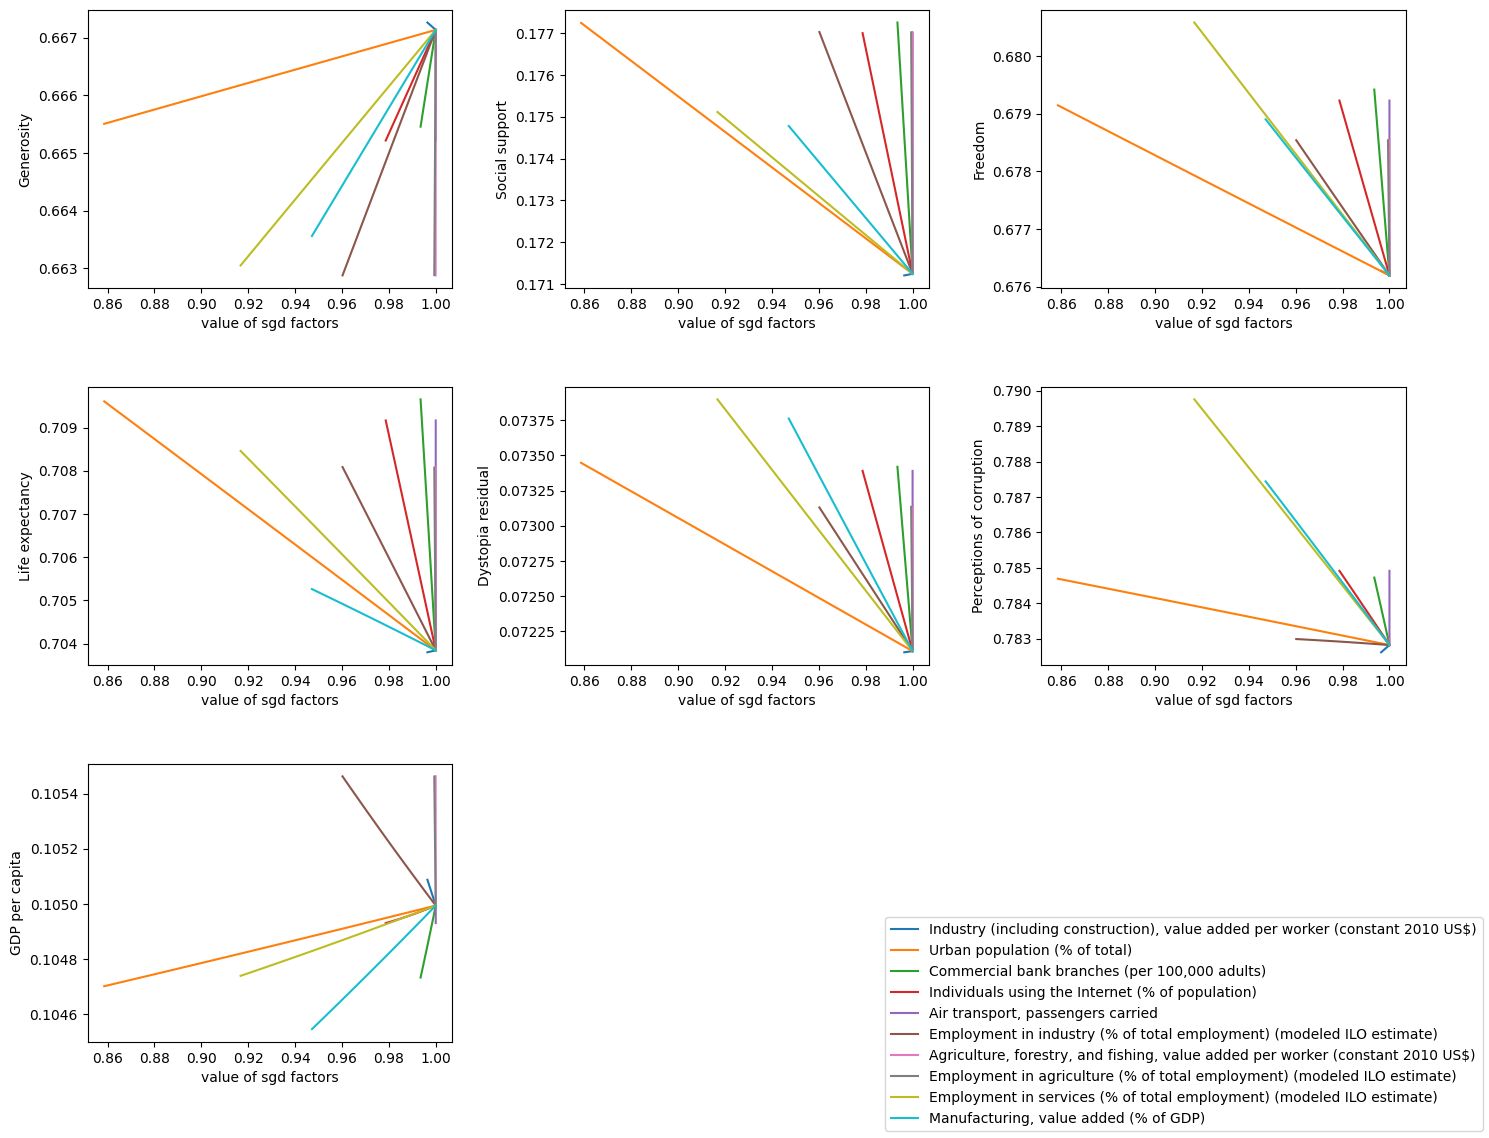

In [17]:
# Visualize the results produced by the model
res = one2many(X, Y)
plotDiff(res, X_columns, y_columns, figure_size=(15, 12))

## Happiness Score Model

In the World Happiness Report, the values of the six factors are computed using a pooled OLS regression. That model makes use of data that is not present in our dataset, thus a linear regression model was used instead. The mean squared error is very small (around 6.9e-8), which suggests that the data is linear.

Happiness scores are predicted as follows:

1. The six factors of happiness and the Dystopia residual are predicted using the indicators of urbanization
2. The predicted values of the previous step are combined to produce the predicted happiness scores

In [18]:
# This dataset is produced in the "preprocessing_all_datasets.ipynb" notebook, and can be found in the generated "tmp" folder
wh_df = pd.read_csv('tmp/wh_all.csv')
wh_df_numeric= wh_df.drop(['Country', 'Country code', 'Year', 'Happiness rank'], axis=1)
wh_df_numeric.head()

,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual
0,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,1.952100
1,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2.145580
2,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2.150801
3,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,2.196000
4,3.203,0.350000,0.517000,0.361000,0.00000,0.025000,0.158000,1.792000


In [19]:
from sklearn.preprocessing import PolynomialFeatures

"""
Splits the given dataframe into two arrays, one containing the independent variables, and the other one containing the
dependent variable. Returns the resulting arrays and an instance of PolynomialFeatures with a degree of 2.
"""
def transform(data):
    X_origin = data.drop('Happiness score', axis=1).to_numpy()
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_origin)
    return X_poly, data['Happiness score'].to_numpy().reshape((-1, 1)), poly_transformer

In [20]:
# Create training and test sets, and transform the training data so that it can be used to train the linear regression model
train, test = train_test_split(wh_df_numeric, test_size=0.1)
X_train, y_train, poly_transformer = transform(train)

In [21]:
from sklearn.linear_model import LinearRegression

poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

LinearRegression()

In [22]:
# Transform the data of the test set, and predict the happiness scores using the model
X_test, y_test, _ = transform(test)
y_preds = poly_model.predict(X_test)

In [23]:
from sklearn.metrics import mean_squared_error

mae = mean_squared_error(y_test, y_preds)
print("MSE:", mae)

MSE: 6.71653754478367e-08


## Urbanization Indicators Modeling

In [24]:
# Load the original Sustainable Development Goals dataset, and extract the selected indicators of urbanization from it
sgd = pd.read_csv('./dataset/world_happiness/sustainable_develop_goals/sdg-csv-zip-7-mb-/SDGData.csv')
sgd_urban = sgd[sgd['Indicator Name'].isin(
    URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS
)].iloc[:, :32].sort_values(by=['Country Name', 'Indicator Name']).reset_index(drop=True)
print(sgd_urban.shape)
sgd_urban

(5260, 32)


,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,587.874492,919.727932,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,NaN,NaN,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,NaN,NaN,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,16.334516,11.030513,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# control length of the sample
# e.g. 12 is the length of the input time serie, 1 is the output
# for a sequence like 6 valid values like [1, 2, 3, 4, 5, 6] with window size 4
# after processing, there will be 3 samples available for training 
# X1, X2, X3, Y
# [1, 2, 3, 4]
# [2, 3, 4, 5]
# [3, 4, 5, 6]
WINDOW_SIZE = 15 + 1

"""
Checks if in the given dataframe, there are any rows in which the last value is a real value,
while the second-to-last value is a NaN entry.

Returns: True if there is at least one row that ends with NaN followed by a real value, False
         otherwise
"""
def nanBeforeTarget(df_tmp):
    h, w = df_tmp.shape
    for i in range(h):
        if not pd.isna(df_tmp.iloc[i, w-1]) and pd.isna(df_tmp.iloc[i, w-2]):
            return True
            
def rename_df2merge(df):
    columns = df.columns
    mapping_dict = {}
    for i in range(WINDOW_SIZE-1):
        mapping_dict[columns[i]] = 'x_' + str(i)
    
    mapping_dict[columns[-1]] = 'y'

    df = df.rename(columns=mapping_dict)
    return df

In [26]:
# for the last one, we take it as output of the sequence
valid_dfs = []
for i in range(0, 5260, 20):
    for j in range(0, sgd_urban.shape[1]-4-WINDOW_SIZE):
        df_tmp = sgd_urban.iloc[i:i+20, j+4:j+WINDOW_SIZE+4]
        if nanBeforeTarget(df_tmp):
            continue
            
        valid_dfs.append(df_tmp)


for i in range(len(valid_dfs)):
    valid_dfs[i] = rename_df2merge(valid_dfs[i])

In [27]:
### time series data preparing

"""
Imputes the given row such that any NaN values that appear before the first real value are replaced
with that real value. NaN values between two real values are approximated by calculating an
increment value, and adding it to the previously known or computed value. If the last value is
NaN, then it will be replaced with the last known value, or 0 if all values of the original
row are NaN.
"""
def impute_row(row):
    row_numeric = row.iloc[4:].to_numpy()

    # Count the number of NaN values at the beginning of the row
    i = 0
    while i < row_numeric.shape[0] and np.isnan(row_numeric[i]):
        # row_numeric[i] = 0
        i += 1
    
    # Replace the NaN values at the beginning of the row with the first known value
    if i < row_numeric.shape[0]:
        row_numeric[0:i] = row_numeric[i]

    j = i + 1

    while i < row_numeric.shape[0]:
        # Skip any known values before the next NaN value
        while i < row_numeric.shape[0] and not np.isnan(row_numeric[i]):
            i += 1

        # Terminate the loop if none of the remaining values need to be imputed
        if i == row_numeric.shape[0]:
            break
        
        # Store the index of the current NaN value in j
        j = i

        # Get the index of the last known value before the current NaN value
        i -= 1 

        # Get the index of the last NaN value before the next known value
        while j < row_numeric.shape[0] and np.isnan(row_numeric[j]):
            j += 1
        
        if j == row_numeric.shape[0]:
            # If the row ends with a NaN value, replace the remaining NaN values with the last known 
            # real value
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i]
        else:
            # Approximate the NaN values between the previous real value and current real value
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i] + (row_numeric[j] - row_numeric[i]) * (index-i) / (j-i)
    
    row.iloc[4:] = row_numeric

    # Replace NaN values with 0 if all values in the row are NaN
    row = row.fillna(0)

    return row

# test impute function, comment out to see the result
# row = sgd_urban.iloc[4, :]
# impute_row(row)

In [28]:
sgd_imputed = sgd_urban.apply(impute_row, axis=1)
# impute all the rows, comment out below to see the result
# sgd_imputed

In [29]:
sgd_imputed.iloc[40:40+20, :]

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
40,Algeria,DZA,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,5.355662e+03,5.355662e+03,5.355662e+03,5.355662e+03,5.355662e+03,5.355662e+03,...,7.893648e+03,1.028872e+04,1.149895e+04,1.382850e+04,1.550116e+04,1.680925e+04,1.894071e+04,2.117516e+04,2.184839e+04,1.976778e+04
41,Algeria,DZA,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,1.460000e+01,2.430000e+01,2.020000e+01,2.130000e+01,2.420000e+01,2.100000e+01,...,1.698500e+01,4.317000e+00,1.590600e+01,1.482600e+01,1.492600e+01,1.750242e+01,2.166233e+01,2.190165e+01,2.159102e+01,2.480375e+01
42,Algeria,DZA,"Air transport, passengers carried",IS.AIR.PSGR,3.748000e+06,3.385000e+06,3.551100e+06,3.254500e+06,3.241000e+06,3.477800e+06,...,2.884506e+06,4.370917e+06,3.372283e+06,3.543663e+06,4.082595e+06,4.492437e+06,5.021289e+06,5.400896e+06,6.093416e+06,6.241924e+06
43,Algeria,DZA,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,6.000000e+01,6.010818e+01,6.021636e+01,6.032455e+01,6.043273e+01,6.054091e+01,...,5.994273e+01,5.976455e+01,5.958636e+01,5.940818e+01,5.923000e+01,5.923000e+01,5.923000e+01,5.923000e+01,5.923000e+01,5.923000e+01
44,Algeria,DZA,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,1.511000e+01,1.453064e+01,1.395127e+01,1.337191e+01,1.279255e+01,1.221318e+01,...,6.311818e+00,5.965364e+00,5.618909e+00,5.272455e+00,4.926000e+00,4.926000e+00,4.926000e+00,4.926000e+00,4.926000e+00,4.926000e+00
45,Algeria,DZA,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,2.970409e+00,2.976898e+00,2.948322e+00,2.958674e+00,3.046885e+00,3.296891e+00,...,3.161381e+00,3.423011e+00,3.299704e+00,3.291376e+00,3.460266e+00,3.507310e+00,3.717410e+00,3.717410e+00,3.717410e+00,3.717410e+00
46,Algeria,DZA,"Commercial bank branches (per 100,000 adults)",FB.CBK.BRCH.P5,4.704244e+00,4.704244e+00,4.704244e+00,4.704244e+00,4.704244e+00,4.704244e+00,...,5.212226e+00,5.142421e+00,5.032357e+00,5.156622e+00,5.200116e+00,5.192307e+00,5.188494e+00,5.234271e+00,5.234463e+00,5.233046e+00
47,Algeria,DZA,"Educational attainment, competed at least Bach...",SE.TER.CUAT.BA.ZS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
48,Algeria,DZA,"Educational attainment, competed at least Mast...",SE.TER.CUAT.MS.ZS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
49,Algeria,DZA,Employment in agriculture (% of total employme...,SL.AGR.EMPL.ZS,2.360300e+01,2.360300e+01,2.330800e+01,2.306200e+01,2.291200e+01,2.278700e+01,...,1.439900e+01,1.296000e+01,1.183700e+01,1.077000e+01,1.020200e+01,9.661000e+00,9.146000e+00,8.656000e+00,8.344000e+00,9.386000e+00


In [30]:
# A list of the urbanization indicator arrays of each country
df_countries = []

NUM_INDICATORS = 20

h, w = sgd_imputed.shape
for i in range(0, h, NUM_INDICATORS):
    # Extract the values of the urbanization indicators of a single country, and add it to the
    # list of countries' indicators
    df_country = sgd_imputed.iloc[i:i+NUM_INDICATORS, 4:].to_numpy()
    df_countries.append(df_country)

# Create a dataframe in which each row contains the possible values of one of the indicators
# of urbanization
sgd_countries = np.concatenate(df_countries, axis=1)

In [31]:
from sklearn.preprocessing import StandardScaler

# Normalize the urbanization indicator values
sgd_scaler = StandardScaler()
sgd_scaler.fit(sgd_countries.T)

# Display the attributes of the scaler
df_sgd_scaler = sgd_urban.iloc[:20, [2]]
df_sgd_scaler['mean'] = sgd_scaler.mean_
df_sgd_scaler['var'] = sgd_scaler.var_
df_sgd_scaler

,Indicator Name,mean,var
0,"Agriculture, forestry, and fishing, value adde...",1.024992e+04,1.878415e+09
1,"Air transport, freight (million ton-km)",3.685362e+03,2.288175e+08
2,"Air transport, passengers carried",6.214632e+07,5.948561e+16
3,"Annual freshwater withdrawals, agriculture (% ...",3.652436e+01,1.388210e+03
4,"Annual freshwater withdrawals, industry (% of ...",1.528193e+01,6.010596e+02
5,CO2 emissions (metric tons per capita),4.611769e+00,4.104882e+01
6,"Commercial bank branches (per 100,000 adults)",1.459914e+01,4.577387e+02
7,"Educational attainment, competed at least Bach...",5.645838e+00,8.521343e+01
8,"Educational attainment, competed at least Mast...",1.918347e+00,1.807323e+01
9,Employment in agriculture (% of total employme...,2.786041e+01,6.119730e+02


In [32]:
## training data preparing
""" convert truncated valid dataframes to numpy array, then merge them
"""
valid_nps = []
for i in range(len(valid_dfs)):
    df_tmp = valid_dfs[i] 
    df_tmp = df_tmp.apply(impute_row, axis=1)
    np_tmp = df_tmp.to_numpy()
    np_tmp_scaled = sgd_scaler.transform(np_tmp.T).T
    valid_nps.append(np_tmp_scaled)

print(len(valid_nps))
valid_nps[0].shape

sgd_ts_data = np.concatenate(valid_nps)
sgd_ts_data.shape

2598


(51960, 16)

In [33]:
ipnn_indicators = list(sgd_urban.iloc[:20, :]['Indicator Name'])
print(ipnn_indicators)

['Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)', 'Air transport, freight (million ton-km)', 'Air transport, passengers carried', 'Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)', 'Annual freshwater withdrawals, industry (% of total freshwater withdrawal)', 'CO2 emissions (metric tons per capita)', 'Commercial bank branches (per 100,000 adults)', "Educational attainment, competed at least Bachelor's or equivalent, population 25+, total (%) (cumulative)", "Educational attainment, competed at least Master's or equivalent, population 25+, total (%) (cumulative)", 'Employment in agriculture (% of total employment) (modeled ILO estimate)', 'Employment in industry (% of total employment) (modeled ILO estimate)', 'Employment in services (% of total employment) (modeled ILO estimate)', 'Forest area (% of land area)', 'Individuals using the Internet (% of population)', 'Industry (including construction), value added per worker (con

In [34]:
import torch.nn as nn
## Model - encoder and decoder manner
"""_summary_
this model is the simplified model, in which we removed the first linear layer in forward, retained the output linear layer
"""
class IndicatorPredictNN(nn.Module):
    def __init__(self, indicators_dim, hidden_size, rnn_hidden, batch_size, rnn_layers=2) -> None:
        super().__init__()

        self.batch_size = batch_size
        self.rnn_layers = rnn_layers
        self.rnn_hidden = rnn_hidden

        self.linear = nn.Linear(indicators_dim, hidden_size)
        self.rnn = nn.LSTM(hidden_size, rnn_hidden, rnn_layers, batch_first=True)
        self.linear5 = nn.Linear(rnn_hidden, indicators_dim)

    
    def init_hidden(indicators_dim, hidden_dim):
        pass
    
    def forward(self, x):
        out = x

        h0, c0 = self.init_hidden(self.batch_size, self.rnn_layers, self.rnn_hidden)
        out, _ = self.rnn(out, (h0, c0))

        out = self.linear5(out[:, -1, :])

        return out


    def init_hidden(self, batch_size, rnn_layers, rnn_hidden, bidirection=False, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        h0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        c0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        return h0, c0
        
        

In [35]:
indicators_dim = sgd_imputed['Indicator Name'].unique().shape[0]
indicators_dim

20

In [73]:
from sklearn.model_selection import train_test_split

data = sgd_ts_data
samples_len = data.shape[0] // 20
data = data.reshape(samples_len, 20, WINDOW_SIZE)
data = data.transpose((0, 2, 1))

train, test = train_test_split(data, test_size=0.1)

print(train.shape)
print(test.shape)

(2338, 16, 20)
(260, 16, 20)


In [74]:
"""_summary_
train Indicator Prediction Neural network
Epoch: 1000
criterion: L1Loss
Optimizer: Adam
"""
model = IndicatorPredictNN(indicators_dim, indicators_dim, indicators_dim*2, 10, 1)
model.to(device)

if not os.path.exists('weights/ipnn.pt'):

    n_epochs = 1000
    lr = 0.01

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train.shape
    X = train[0:10, :WINDOW_SIZE-1, :]
    y = train[0:10, WINDOW_SIZE-1, :]

    losses = []
    test_losses = []
    for epoch in range(1, n_epochs):
        optimizer.zero_grad()
        loss_total = 0

        for i in range(21):
            X = torch.Tensor(train[i*10:(i+1)*10, :WINDOW_SIZE-1, :]).to(device)
            y = torch.Tensor(train[i*10:(i+1)*10, WINDOW_SIZE-1, :]).to(device)

            out = model(X)
            loss = criterion(out, y)

            loss.backward()

            loss_total += loss.item()
        
        optimizer.step()

        loss_total_test = 0
        for i in range(test.shape[0] // 10):
            start = i*10
            end = (i+1)*10
            if end > test.shape[0]:
                start = end - 10
            
            X_test = torch.Tensor(test[start:end, :WINDOW_SIZE-1, :]).to(device)
            y_test = torch.Tensor(test[start:end, WINDOW_SIZE-1, :]).to(device)

            out = model(X_test)
            loss = criterion(out, y_test)

            loss_total_test += loss.item()


        losses.append(loss_total)
        test_losses.append(loss_total_test)
        
        if epoch%10 == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {:.4f}".format(loss_total))


    torch.save(model.state_dict(), 'weights/ipnn.pt')

    ## total loss every 10 epoch
    plt.plot(losses)
    plt.plot(test_losses)
    plt.legend(['train loss', 'test loss'])
    plt.title('overall')
    plt.show()


    ## average loss on each sample
    single_losses = np.array(losses) / 210
    single_test_losses = np.array(test_losses) / (test.shape[0] // 10)

    plt.plot(single_losses)
    plt.plot(single_test_losses)
    plt.legend(['train loss', 'test loss'])
    plt.title('single')

else:
    model.load_state_dict(torch.load('weights/ipnn.pt'))
    model.eval()

ipnn = model

In [39]:
# predict future
## index transform
"""_summary_
index remapping array, which maps index in IPNN inputs to index in FPNN inputs
e.g.
IPNN input: ['a', 'b']
FPNN input: ['b', 'a']
mapping: [1, 0]
"""
fpnn_idx_in_ipnn = []
for index_name in fpnn_input_columns:
    fpnn_idx_in_ipnn.append(ipnn_indicators.index(index_name))  
    

print(fpnn_idx_in_ipnn)

[14, 19, 6, 13, 2, 10, 0, 9, 11, 15]


In [75]:
"""_summary_
10 countries a batch, prepare all countries urbanization indicators data for inference
"""
num_countries = 10

nation_numeric = sgd_imputed.iloc[:20*num_countries, 4:].to_numpy()
nation_numeric.shape

for i in range(0, 20*num_countries, 20):
    tmp = nation_numeric[i:i+20, :]
    tmp = sgd_scaler.transform(tmp.T).T
    nation_numeric[i:i+20, :] = tmp

nation_numeric.shape
nation_numeric = nation_numeric.reshape(10, 20, 28)
nation_numeric = nation_numeric.transpose((0, 2, 1))
nation_numeric_tensor = torch.Tensor(nation_numeric).to(device)
nation_numeric_tensor.shape

torch.Size([10, 28, 20])

In [76]:
# predict next year bese on a time series
"""_summary_
urbanization indicators prediction
predict X_t based on [X_t-1 ... X_t-n]
"""
def onestep(X):
    y = model(X) 
    return y

In [77]:
"""_summary_
urbanization indicators prediction
predict [X_t+c .. X_t] based on [X_t-1 ... X_t-n]
"""
def getNextNYear(n, X):
    for i in range(n):
        y = model(X).reshape(10, 1, 20)
        X = torch.concat((X, y), 1)
    
    return X[:, -n:, :]

In [43]:
"""_summary_
get prediction for all countries in the next 15 years and store all result into a dict
"""
from math import ceil

# how many years want to predict
years = 15

nations_total = sgd_imputed.shape[0] // 20

nextYears = []

for i in range(ceil(nations_total/10)):
    start = i*10*20
    end = (i+1)*10*20

    if end > sgd_imputed.shape[0]:
        end = sgd_imputed.shape[0]
        start = end - 10*20

    nation_numeric = sgd_imputed.iloc[start:end, 4:].to_numpy()

    for j in range(0, end-start, 20):
        tmp = nation_numeric[j:j+20, :]
        tmp = sgd_scaler.transform(tmp.T).T
        nation_numeric[j:j+20, :] = tmp

    nation_numeric = nation_numeric.reshape(10, 20, 28)
    nation_numeric = nation_numeric.transpose([0, 2, 1])

    X = torch.Tensor(nation_numeric).to(device)
    X_next10 = getNextNYear(years, X)

    nextYears.append({
        "start": start,
        "end": end,
        "preds": X_next10.cpu().detach().numpy()
    })
    

In [78]:
"""_summary_
merge all prediction results from the above cell
"""
# predict future
newCols = []
for i in range(2019, 2019+years):
    newCols.append(str(i))

sgd_preds = sgd_imputed.iloc[:, :4]
sgd_preds = sgd_preds.reindex(columns=list(sgd_preds.columns) + newCols)

for item in nextYears:
    start = item['start']
    end = item['end']
    preds = item['preds']
    preds = preds.transpose([0, 2, 1])
    preds = preds.reshape((end-start), years)
    sgd_preds.iloc[start:end, 4:] = preds

sgd_preds

,Country Name,Country Code,Indicator Name,Indicator Code,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,-0.237814,-0.259424,-0.277989,-0.292543,-0.304347,-0.314192,-0.322613,-0.329891,-0.336085,-0.341088,-0.344649,-0.346383,-0.345773,-0.342176,-0.334850
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,-0.246656,-0.248587,-0.245394,-0.240152,-0.234951,-0.230443,-0.226789,-0.224050,-0.222259,-0.221429,-0.221553,-0.222598,-0.224517,-0.227306,-0.231155
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,-0.260618,-0.262600,-0.259766,-0.254474,-0.248592,-0.242644,-0.236861,-0.231410,-0.226397,-0.221871,-0.217814,-0.214157,-0.210805,-0.207749,-0.205276
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,1.661596,1.646935,1.621604,1.589522,1.553806,1.515560,1.474992,1.431984,1.386269,1.337510,1.285346,1.229450,1.169591,1.105716,1.038043
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,-0.579451,-0.560850,-0.541377,-0.521428,-0.501134,-0.480012,-0.457586,-0.433568,-0.407803,-0.380238,-0.350897,-0.319886,-0.287379,-0.253636,-0.219017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,-0.127057,-0.141055,-0.133336,-0.109287,-0.074016,-0.031299,0.014544,0.059027,0.097715,0.126304,0.140499,0.135605,0.106046,0.045898,-0.046484
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,-0.758589,-0.756835,-0.737024,-0.703105,-0.659149,-0.608474,-0.553451,-0.495627,-0.435734,-0.373689,-0.308626,-0.238952,-0.162505,-0.077222,0.016142
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,-0.170533,-0.193548,-0.220850,-0.247699,-0.275117,-0.303494,-0.333076,-0.363887,-0.395711,-0.428272,-0.461616,-0.496600,-0.535359,-0.581376,-0.637687
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,-0.152649,-0.144604,-0.137424,-0.127918,-0.115448,-0.100234,-0.082392,-0.061999,-0.039241,-0.014527,0.011417,0.037440,0.061774,0.081684,0.093289


In [45]:
# merge preds and old time series
sgd_preds_scaled_back = sgd_preds.iloc[:, :4]
sgd_preds_scaled_back = sgd_preds_scaled_back.reindex(columns=list(sgd_preds_scaled_back.columns) + newCols)
sgd_preds_scaled_back

h, w = sgd_preds.shape
for i in range(0, h, 20):
    tmp = sgd_preds.iloc[i:i+20, 4:]
    tmp = sgd_scaler.inverse_transform(tmp.T).T
    sgd_preds_scaled_back.iloc[i:i+20, 4:] = tmp
    
sgd_preds_and_old = pd.merge(sgd_imputed, sgd_preds_scaled_back, how='inner', on=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
sgd_preds_and_old

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,797.056204,797.056204,797.056204,797.056204,797.056204,797.056204,...,-3.367365e+03,-3.732362e+03,-4.047773e+03,-4.316228e+03,-4.533065e+03,-4.687415e+03,-4.762569e+03,-4.736104e+03,-4.580226e+03,-4.262725e+03
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,1.995189e+02,2.547861e+02,2.962170e+02,3.233189e+02,3.358722e+02,3.339887e+02,3.181887e+02,2.891555e+02,2.469632e+02,1.887526e+02
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,2.966276e+06,4.376736e+06,5.706223e+06,6.928736e+06,8.032799e+06,9.022148e+06,9.914190e+06,1.073166e+07,1.147696e+07,1.208014e+07
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,98.620000,98.620000,98.620000,98.620000,98.620000,98.620000,...,9.299215e+01,9.148063e+01,8.987821e+01,8.817495e+01,8.635824e+01,8.441467e+01,8.233205e+01,8.010179e+01,7.772187e+01,7.520048e+01
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,0.633600,0.633600,0.633600,0.633600,0.633600,0.633600,...,3.513715e+00,4.063518e+00,4.652356e+00,5.284012e+00,5.959829e+00,6.679145e+00,7.439434e+00,8.236397e+00,9.063648e+00,9.912394e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,1.204089e+01,1.241556e+01,1.277910e+01,1.309529e+01,1.332894e+01,1.344495e+01,1.340495e+01,1.316337e+01,1.267180e+01,1.191679e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.673871e+00,3.583177e+00,4.538783e+00,5.528579e+00,6.553926e+00,7.629171e+00,8.780598e+00,1.004398e+01,1.145336e+01,1.299630e+01
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,...,-3.771089e+04,-4.511980e+04,-5.283677e+04,-6.080723e+04,-6.896232e+04,-7.731375e+04,-8.607565e+04,-9.578309e+04,-1.073084e+05,-1.214118e+05
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.075738e+03,4.139743e+03,5.355813e+03,6.712990e+03,8.186839e+03,9.733990e+03,1.128585e+04,1.273696e+04,1.392429e+04,1.461639e+04


In [46]:
from math import ceil

"""_summary_
plot old indicators and predications
"""
def plotIndicators(country):
    sgd_country = sgd_preds_and_old[sgd_preds_and_old['Country Code'] == country]
    sgd_country

    col_per_row = 5

    fig, ax = plt.subplots(ceil(sgd_country.shape[0] / col_per_row), col_per_row)

    fig.set_size_inches(24, 12)
    fig.tight_layout(pad=2.0)

    for i in range(sgd_country.shape[0]):
        index = sgd_country['Indicator Name'].iloc[i]
        indicator_values = sgd_country[sgd_country['Indicator Name'] == index].iloc[:, 4:].to_numpy().reshape(-1, 1)

        old = indicator_values[:27]
        new = indicator_values[27:]
        old_ranges = range(1990, 1990+27)
        new_ranges = range(1990+27, 1990+indicator_values.shape[0])

        row = i // col_per_row
        col = i % col_per_row
        ax[row, col].plot(old_ranges, old)
        ax[row, col].plot(new_ranges, new, color='orange')
        ax[row, col].title.set_text(index[:40])


In [47]:
## available countries to plot
print(sgd_imputed['Country Code'].unique())

['AFG' 'ALB' 'DZA' 'ASM' 'AND' 'AGO' 'ATG' 'ARB' 'ARG' 'ARM' 'ABW' 'AUS'
 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ' 'BEN' 'BMU' 'BTN'
 'BOL' 'BIH' 'BWA' 'BRA' 'VGB' 'BRN' 'BGR' 'BFA' 'BDI' 'CPV' 'KHM' 'CMR'
 'CAN' 'CSS' 'CYM' 'CAF' 'CEB' 'TCD' 'CHI' 'CHL' 'CHN' 'COL' 'COM' 'COD'
 'COG' 'CRI' 'CIV' 'HRV' 'CUB' 'CUW' 'CYP' 'CZE' 'DNK' 'DJI' 'DMA' 'DOM'
 'EAR' 'EAS' 'TEA' 'EAP' 'ECU' 'EGY' 'SLV' 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH'
 'EMU' 'ECS' 'TEC' 'ECA' 'EUU' 'FRO' 'FJI' 'FIN' 'FCS' 'FRA' 'PYF' 'GAB'
 'GMB' 'GEO' 'DEU' 'GHA' 'GIB' 'GRC' 'GRL' 'GRD' 'GUM' 'GTM' 'GIN' 'GNB'
 'GUY' 'HTI' 'HPC' 'HIC' 'HND' 'HKG' 'HUN' 'IBD' 'IBT' 'IDB' 'IDX' 'IDA'
 'ISL' 'IND' 'IDN' 'IRN' 'IRQ' 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN' 'JOR'
 'KAZ' 'KEN' 'KIR' 'PRK' 'KOR' 'XKX' 'KWT' 'KGZ' 'LAO' 'LTE' 'LCN' 'TLA'
 'LAC' 'LVA' 'LDC' 'LBN' 'LSO' 'LBR' 'LBY' 'LIE' 'LTU' 'LMY' 'LIC' 'LMC'
 'LUX' 'MAC' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT' 'MHL' 'MRT' 'MUS' 'MEX'
 'FSM' 'MEA' 'TMN' 'MNA' 'MIC' 'MDA' 'MCO' 'MNG' 'M

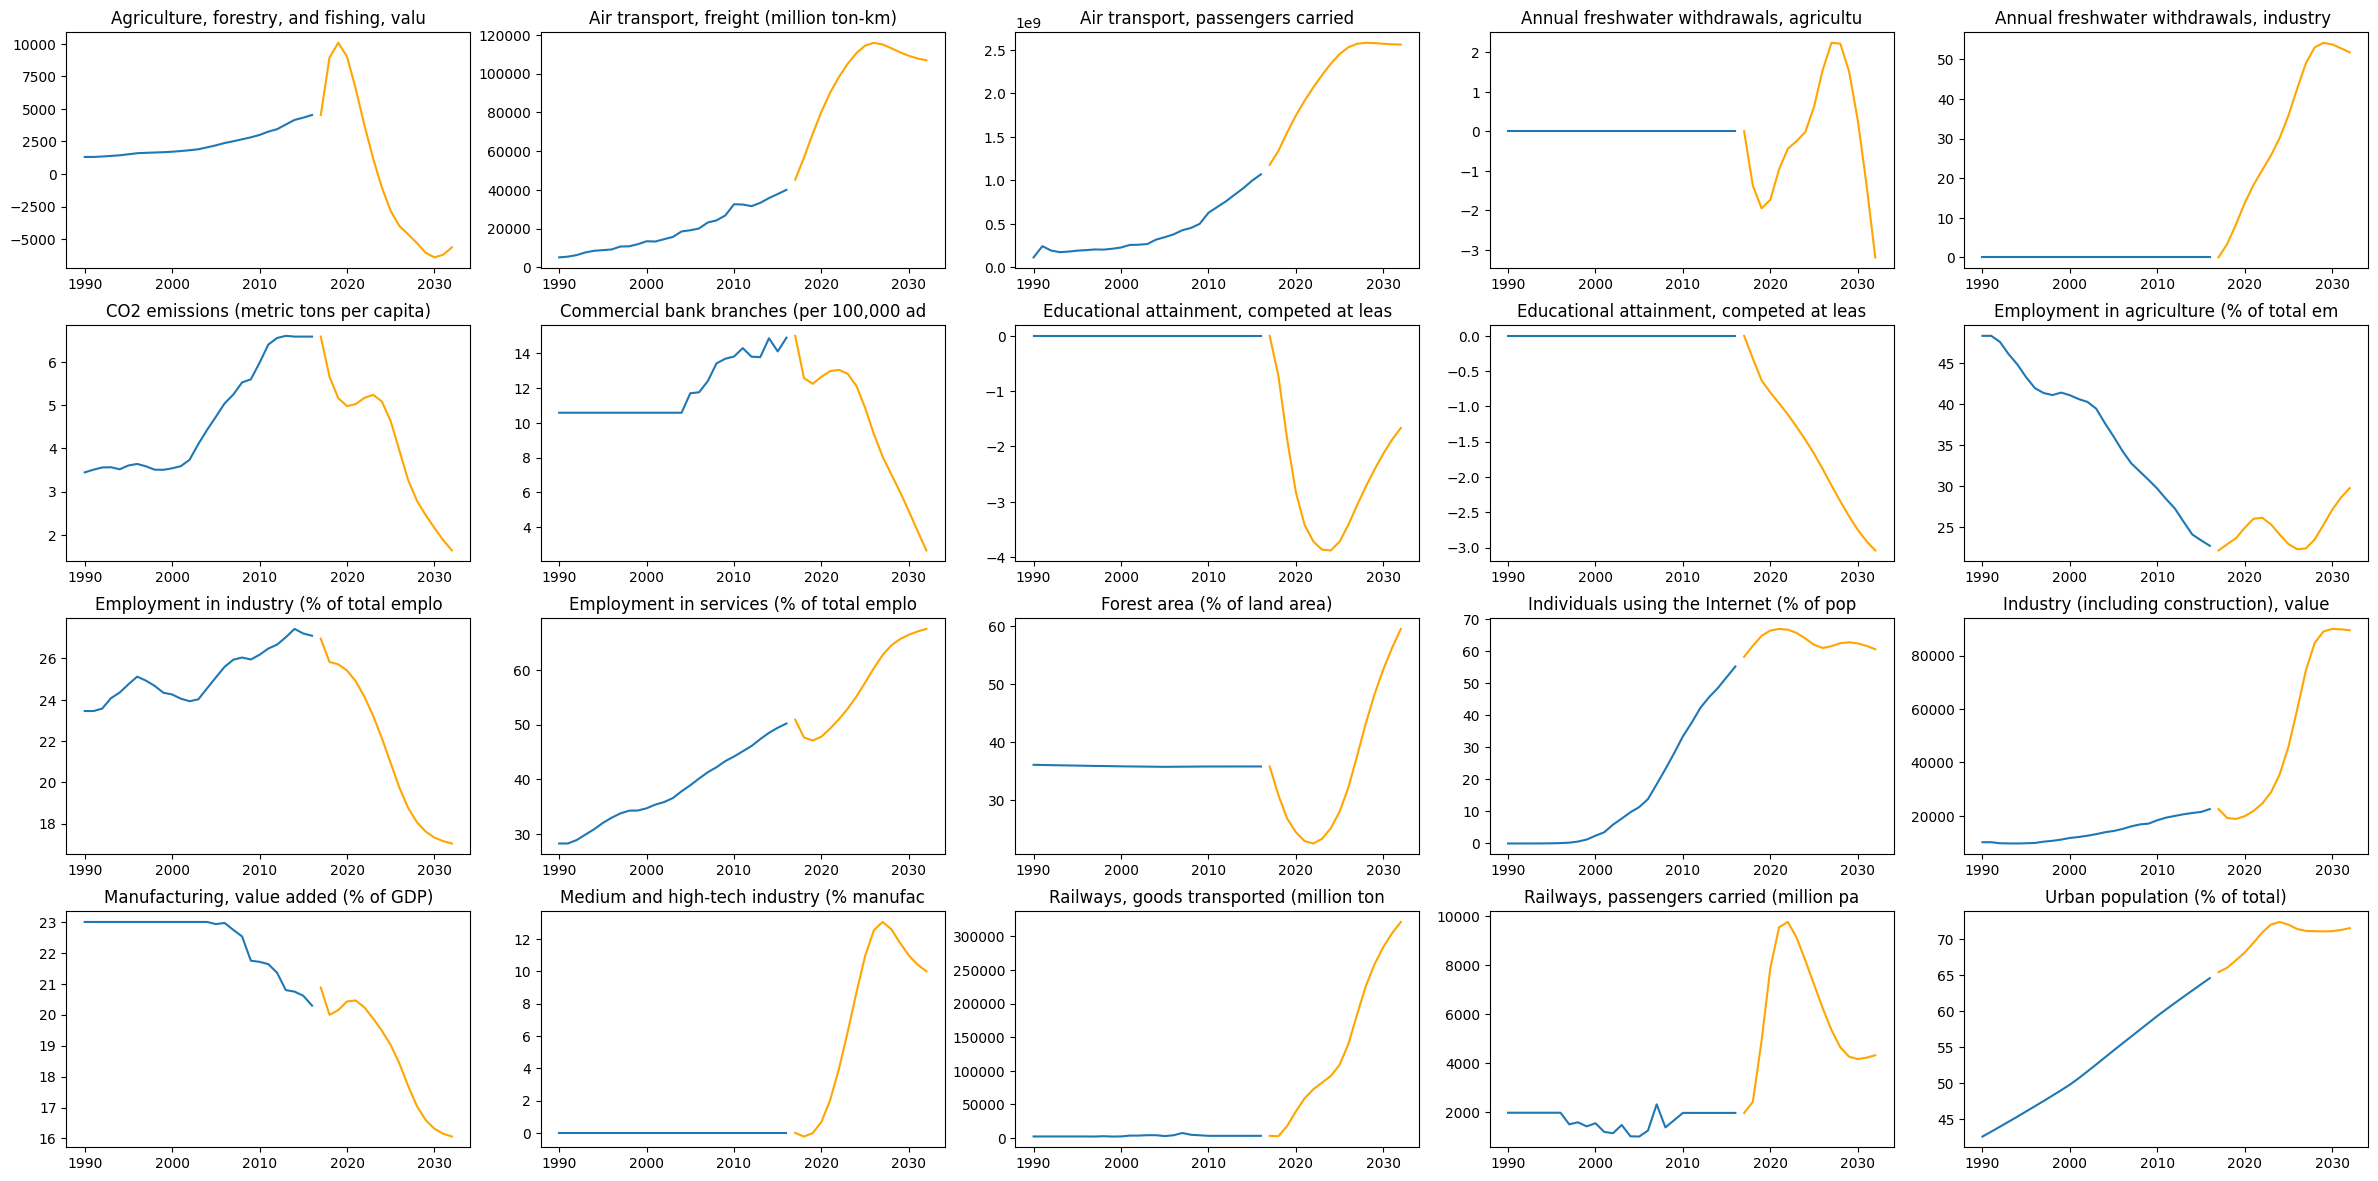

In [48]:
plotIndicators('UMC')

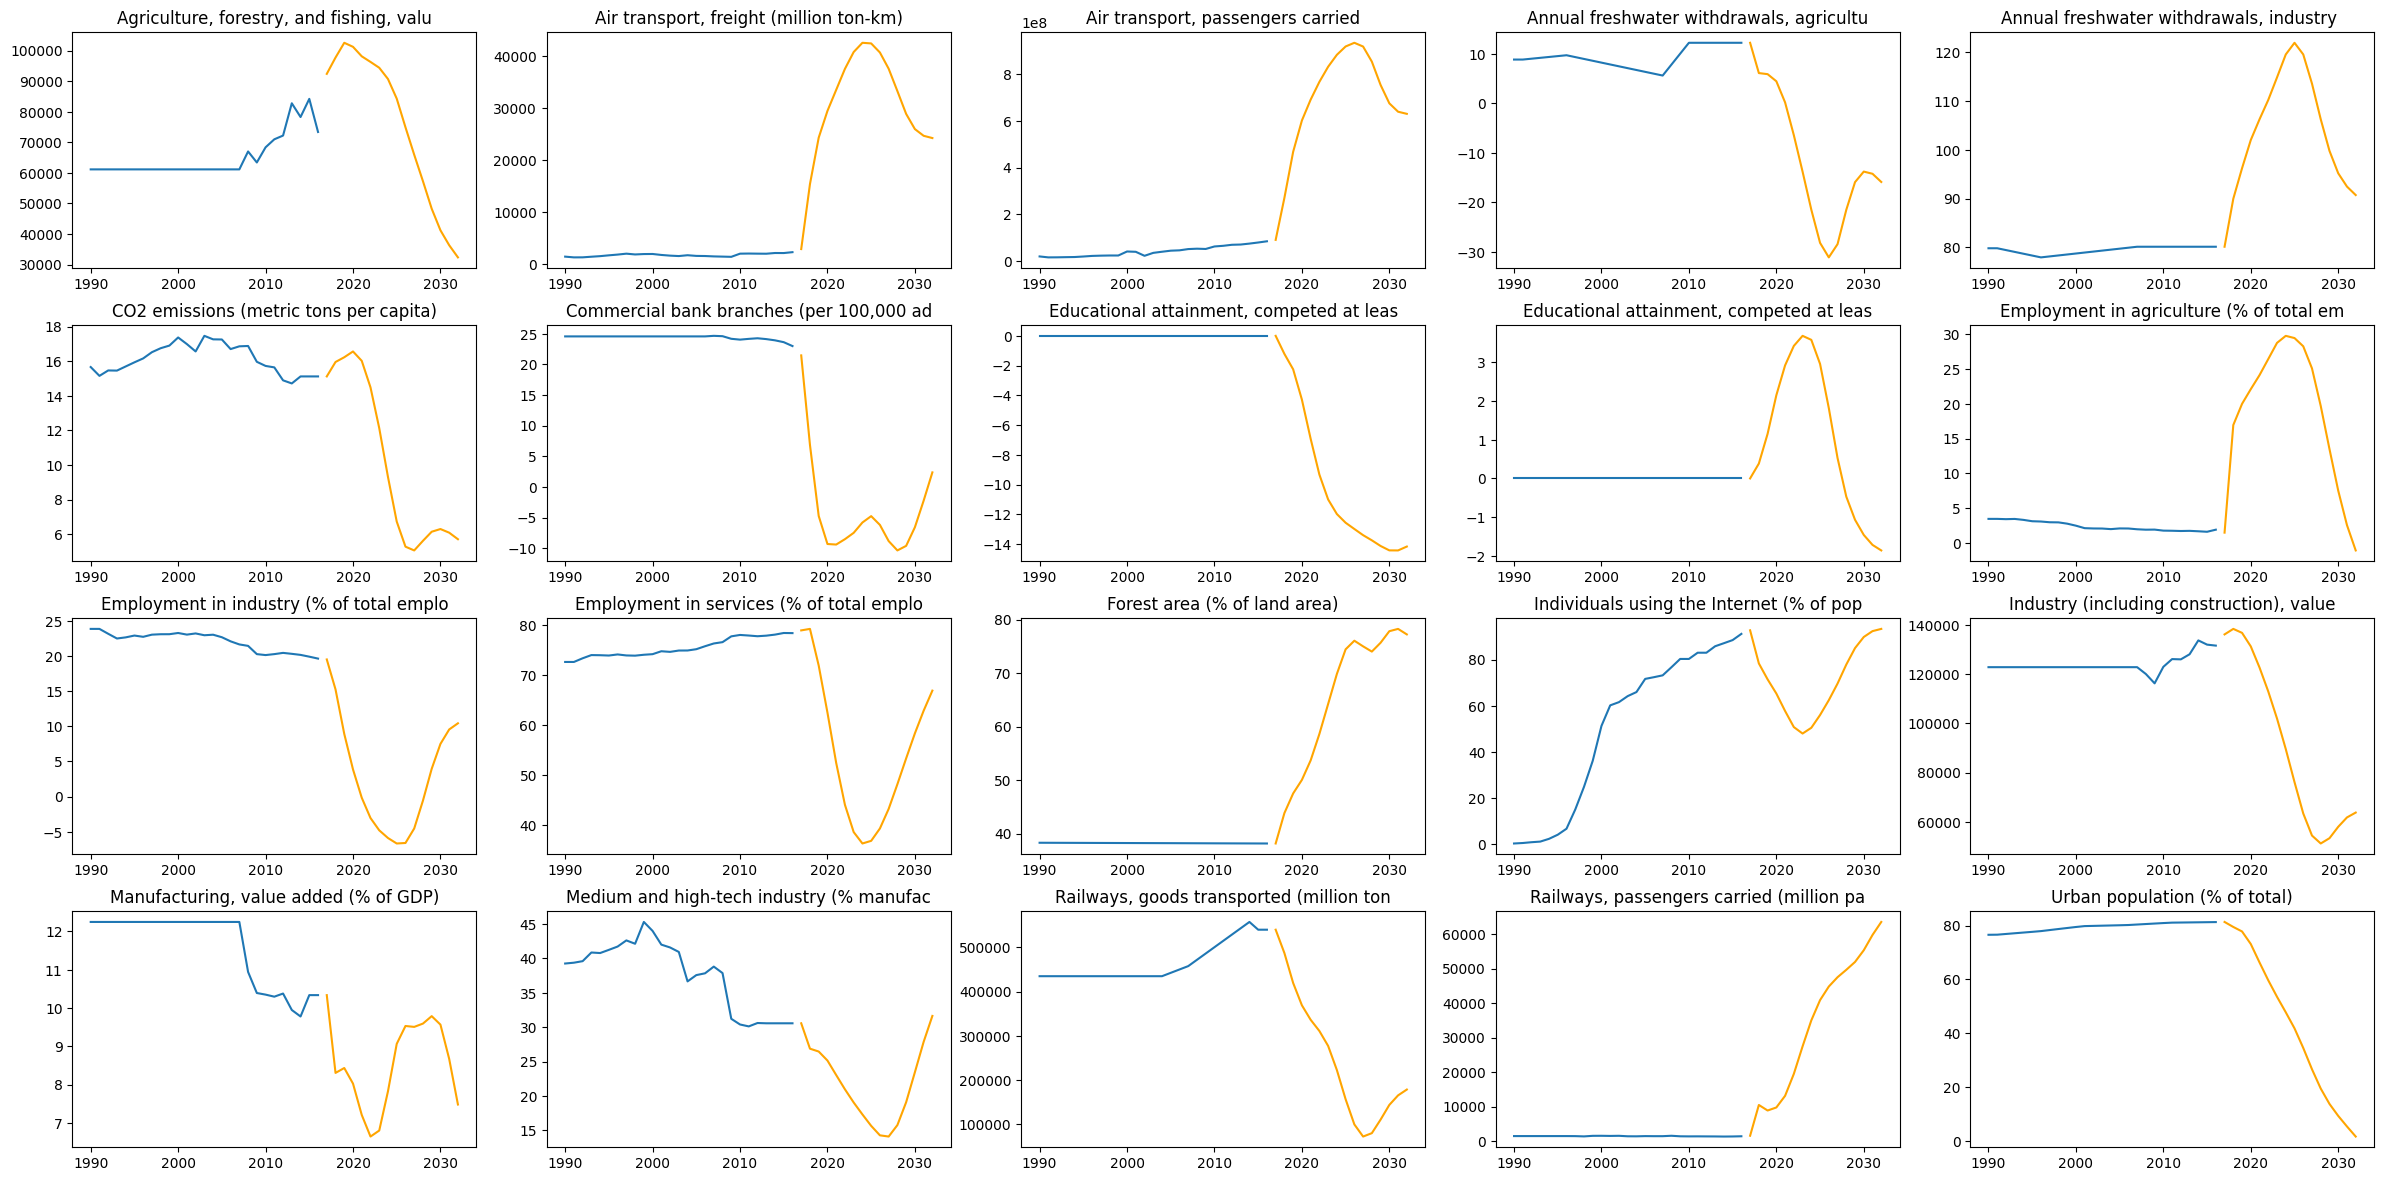

In [49]:
plotIndicators('CAN')

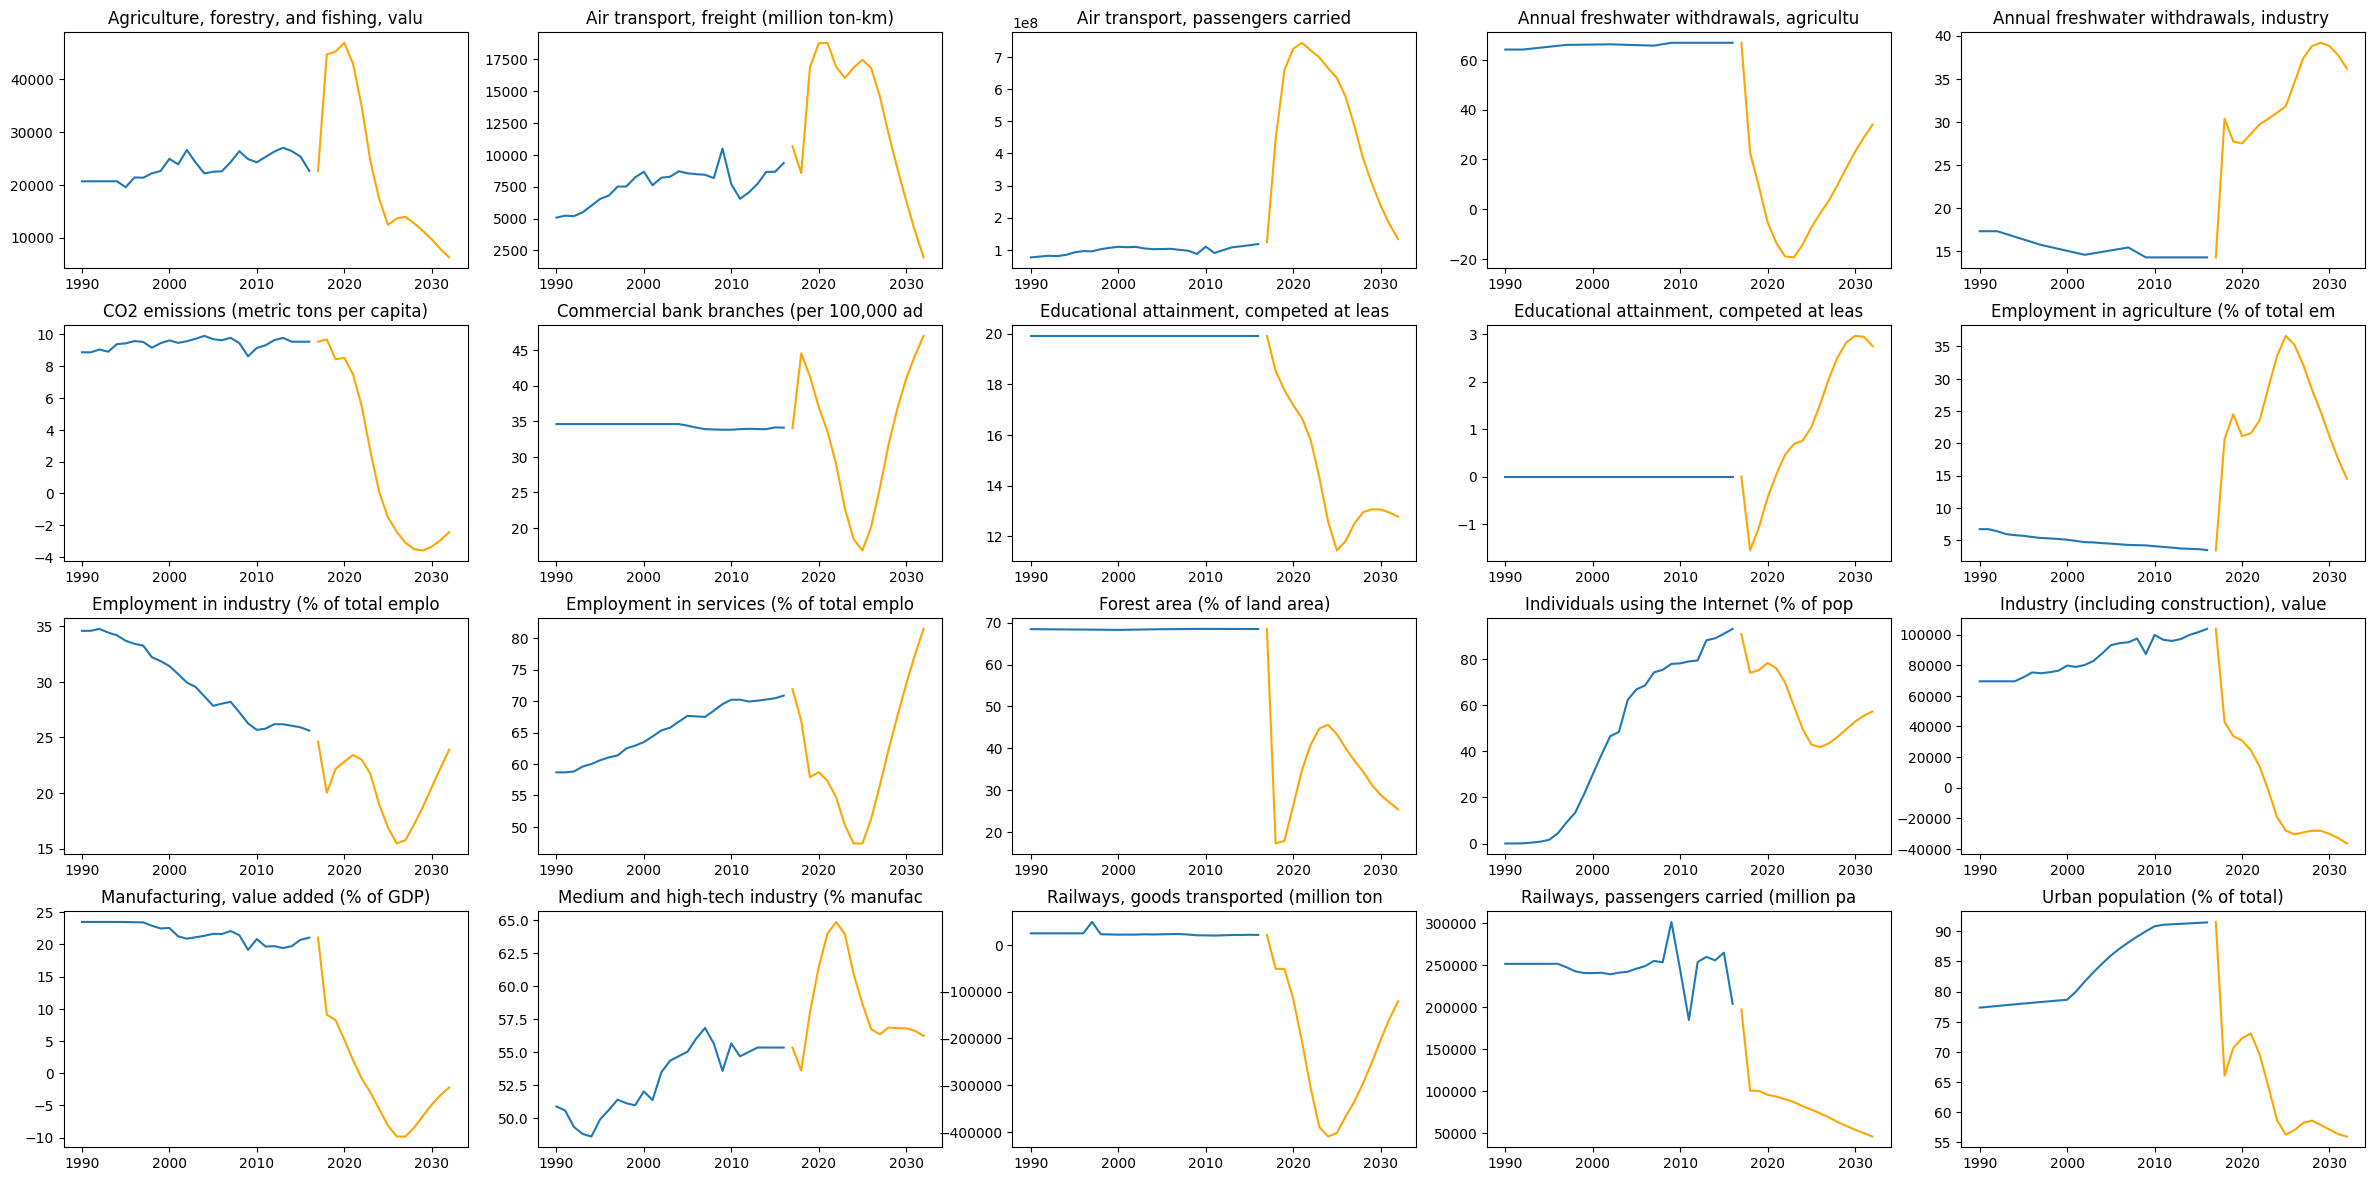

In [50]:
plotIndicators('JPN')

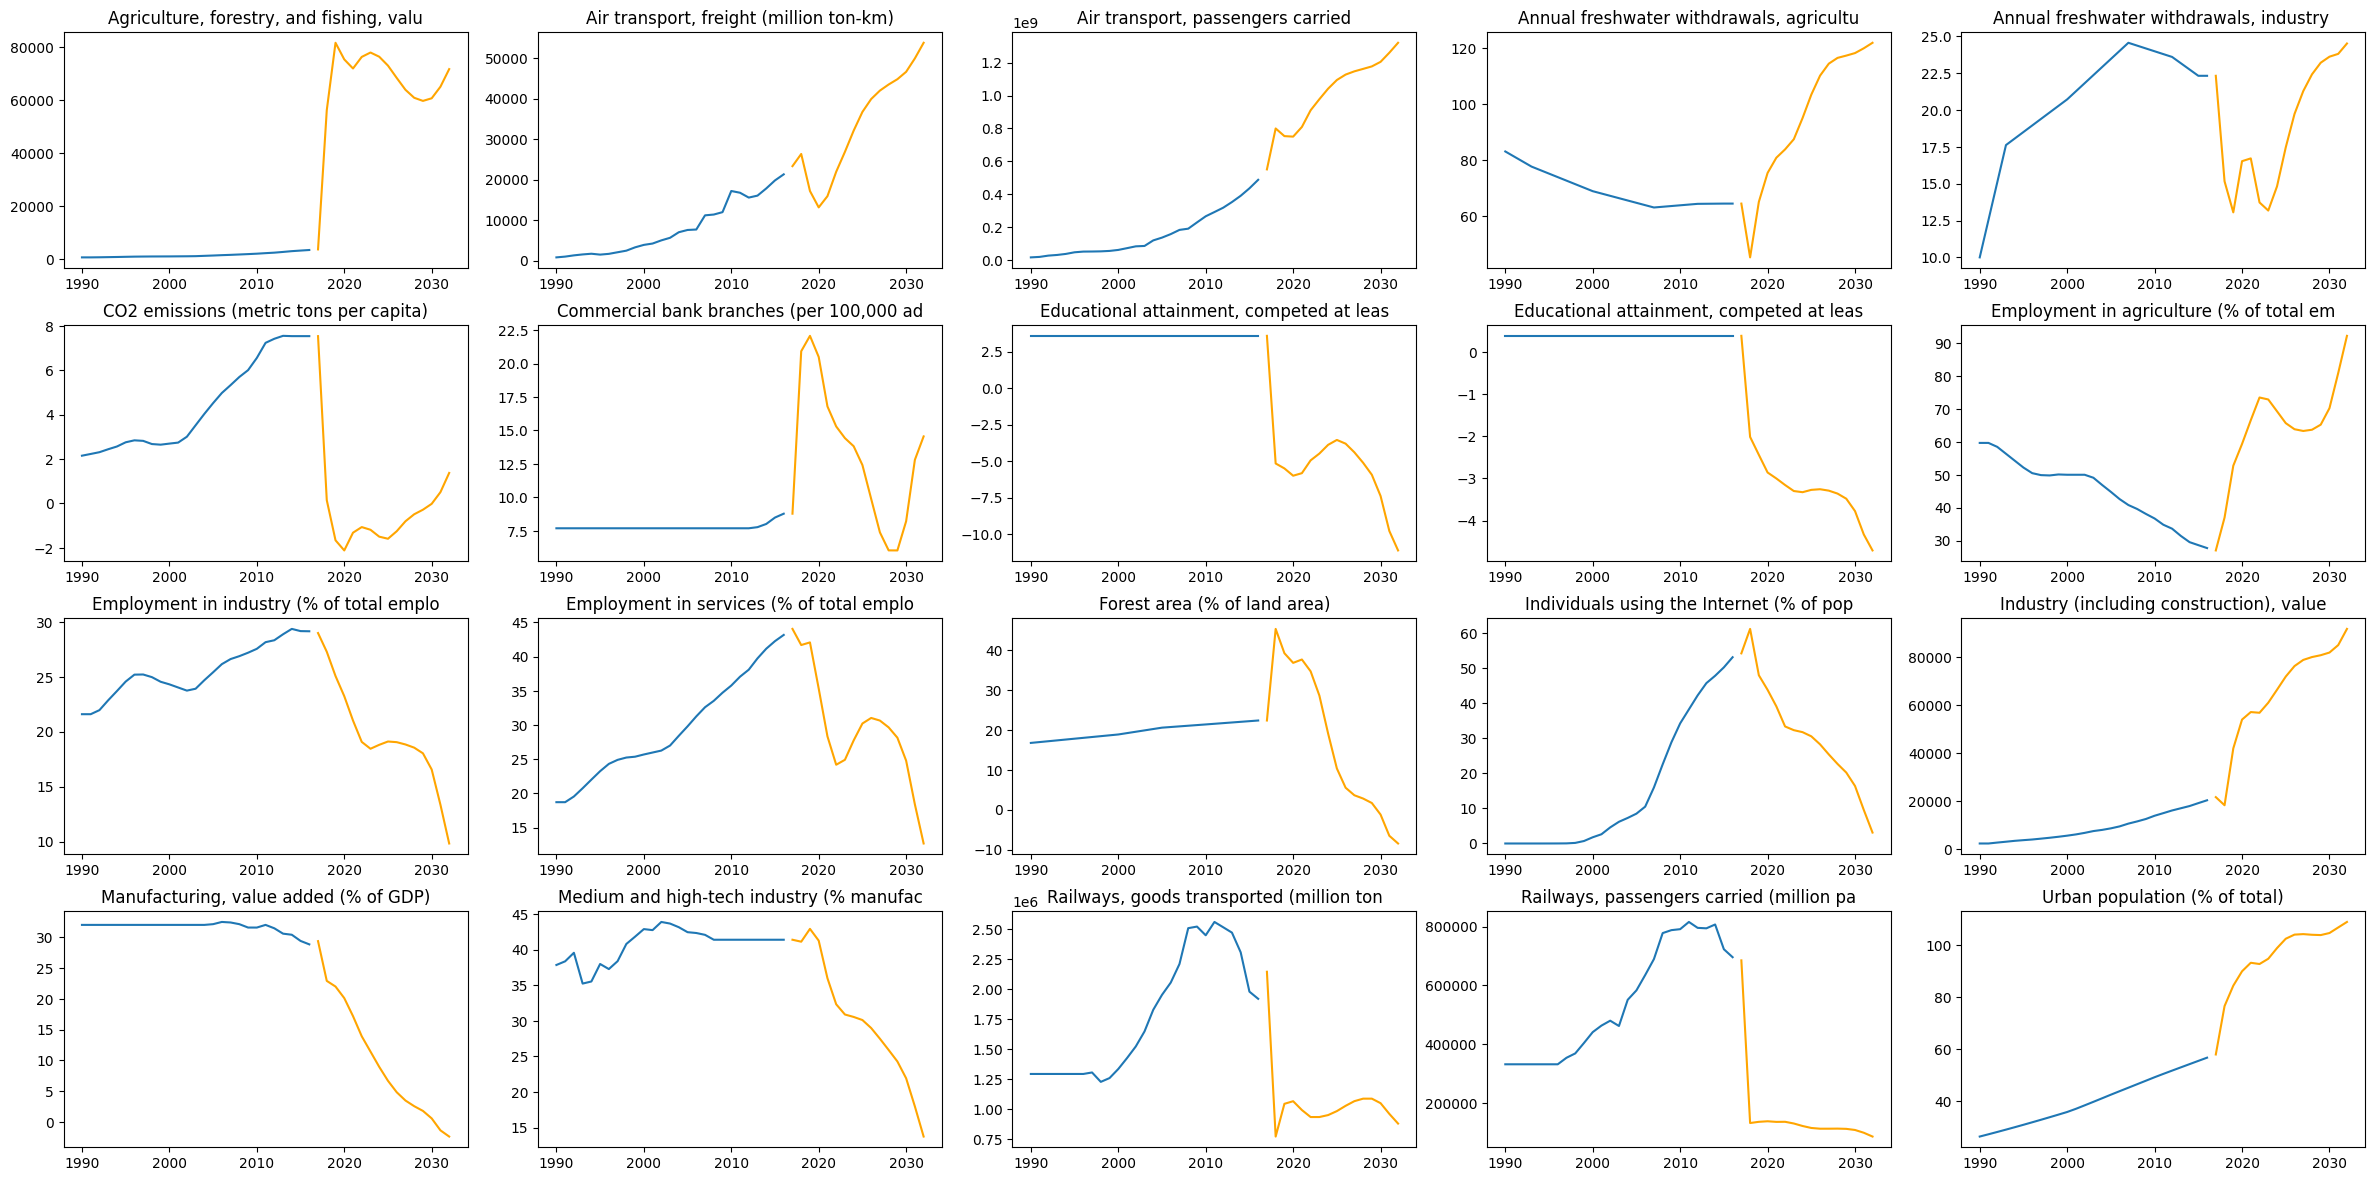

In [51]:
plotIndicators('CHN')

In [52]:
# predict future scores, reorder predictions from IPNN to put into FPNN for world happiness factors prediction
fpnn_df = sgd_preds_and_old[sgd_preds_and_old['Indicator Name'].isin(fpnn_input_columns)].reset_index(drop=True)

current_order = fpnn_df.iloc[:10, :]['Indicator Name'].to_list()
wanted_order = list(fpnn_input_columns)
current_order
wanted_order

cur2wanted_mapping = []
for idx in wanted_order:
    cur2wanted_mapping.append(current_order.index(idx)) 

print(cur2wanted_mapping)

[7, 9, 2, 6, 1, 4, 0, 3, 5, 8]


In [79]:
"""_summary_
predict given country's world happiness factors base on SGD data
"""
def getCountryWHPredictedFeatures(countryCode):
    country_code = countryCode
    country_data = fpnn_df[fpnn_df['Country Code'] == country_code].reset_index(drop=True)
    country_data_reordered = country_data.iloc[cur2wanted_mapping, :]
    idx2iter = country_data_reordered.columns[4:]
    idx2iter

    fpnn_preds = {}

    for idx in list(idx2iter):
        raw = country_data_reordered.loc[:, idx].to_numpy()
        scaled = X_scaler.transform(raw.reshape(1, 10))
        X = torch.Tensor(scaled).to(device)
        y = fpnn(X).cpu().detach().numpy()

        y = Y_scaler.inverse_transform(y)
        fpnn_preds[idx] = y
    
    return fpnn_preds


In [54]:
def getHappinessScore(X):
    X_poly = poly_transformer.transform(X)
    y = poly_model.predict(X_poly)
    return y

In [55]:
wh_df = pd.read_csv('tmp/wh_all.csv')

In [56]:
def plotHappiness(countryCode):
    country = countryCode
    can_wh_preds = getCountryWHPredictedFeatures(country)
    old = wh_df[wh_df['Country code'] == country]['Happiness score'].to_numpy()[:-1]
    
    old_ranges = range(2015, 2019)
    new = []
    new_ranges = [year for year in range(2019, 2034)]
        
    for idx in new_ranges:
        new.append(getHappinessScore(can_wh_preds[str(idx)])[0][0]) 
    

    if len(old) > 0: 
        new_ranges.insert(0, 2018)
        new.insert(0, old[-1])


    # whc = np.array(whc)
    # print(whc.shape)
    # print(whc_old.shape)

    # whc2plot = np.concatenate((whc_old, whc))
    # x = [str(year) for year in range(2015, 2015 + len(whc2plot))]


    plt.figure(figsize=(12, 6))
    if len(old) > 0: plt.plot(old_ranges,old)
    plt.plot(new_ranges, new, color='orange')
    plt.xlabel('date')
    plt.ylabel('happiness score')
    plt.title(f'{country} happiness scores')

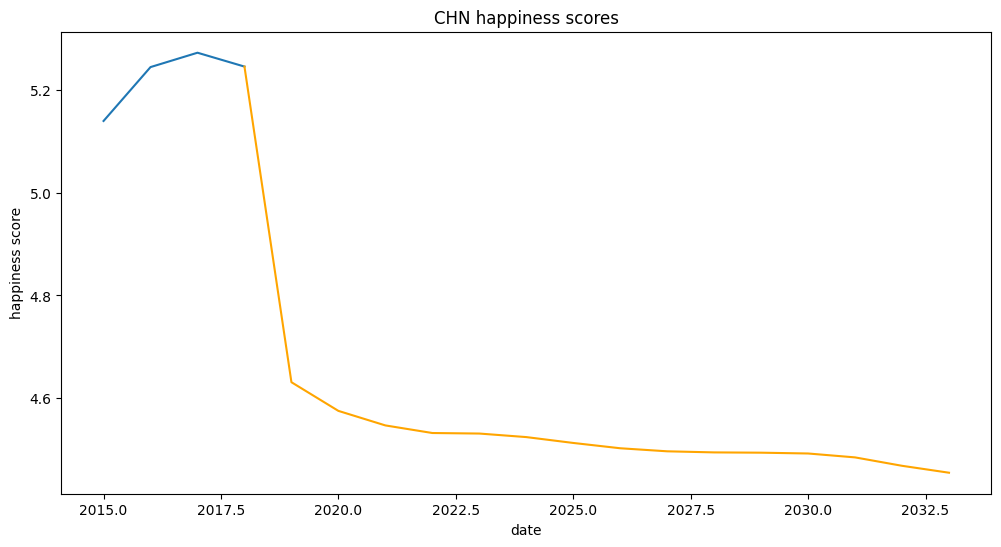

In [57]:
plotHappiness('CHN')

## Modified LSTM Trained with a Single Country

In [82]:
# filter selected country's indicators' values
Country = 'Canada'
canada = sgd_imputed[sgd_imputed['Country Name'] == Country]
canada

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
720,Canada,CAN,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,6.115363e+04,6.115363e+04,6.115363e+04,6.115363e+04,6.115363e+04,6.115363e+04,...,6.701860e+04,6.341564e+04,6.837461e+04,7.099722e+04,7.222021e+04,8.279364e+04,7.828812e+04,8.423494e+04,7.339391e+04,9.242034e+04
721,Canada,CAN,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,1.385300e+03,1.241400e+03,1.249700e+03,1.369200e+03,1.478600e+03,1.637400e+03,...,1.388665e+03,1.346938e+03,1.957329e+03,1.980000e+03,1.960000e+03,1.946306e+03,2.084318e+03,2.074831e+03,2.246227e+03,2.840985e+03
722,Canada,CAN,"Air transport, passengers carried",IS.AIR.PSGR,2.060140e+07,1.658650e+07,1.681830e+07,1.751650e+07,1.810480e+07,2.029110e+07,...,5.371876e+07,5.258352e+07,6.327741e+07,6.607801e+07,7.046740e+07,7.152673e+07,7.552861e+07,8.022830e+07,8.540642e+07,9.140400e+07
723,Canada,CAN,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,8.851000e+00,8.851000e+00,9.025400e+00,9.199800e+00,9.374200e+00,9.548600e+00,...,7.826667e+00,1.003333e+01,1.224000e+01,1.224000e+01,1.224000e+01,1.224000e+01,1.224000e+01,1.224000e+01,1.224000e+01,1.224000e+01
724,Canada,CAN,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,7.984000e+01,7.984000e+01,7.946600e+01,7.909200e+01,7.871800e+01,7.834400e+01,...,8.015000e+01,8.015000e+01,8.015000e+01,8.015000e+01,8.015000e+01,8.015000e+01,8.015000e+01,8.015000e+01,8.015000e+01,8.015000e+01
725,Canada,CAN,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1.565907e+01,1.514926e+01,1.546231e+01,1.545363e+01,1.569288e+01,1.593098e+01,...,1.687520e+01,1.596156e+01,1.572317e+01,1.563976e+01,1.489064e+01,1.471197e+01,1.511716e+01,1.511716e+01,1.511716e+01,1.511716e+01
726,Canada,CAN,"Commercial bank branches (per 100,000 adults)",FB.CBK.BRCH.P5,2.457829e+01,2.457829e+01,2.457829e+01,2.457829e+01,2.457829e+01,2.457829e+01,...,2.461283e+01,2.418642e+01,2.405060e+01,2.417498e+01,2.427366e+01,2.413700e+01,2.393554e+01,2.363553e+01,2.300082e+01,2.147890e+01
727,Canada,CAN,"Educational attainment, competed at least Bach...",SE.TER.CUAT.BA.ZS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
728,Canada,CAN,"Educational attainment, competed at least Mast...",SE.TER.CUAT.MS.ZS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
729,Canada,CAN,Employment in agriculture (% of total employme...,SL.AGR.EMPL.ZS,3.491000e+00,3.491000e+00,3.451000e+00,3.483000e+00,3.348000e+00,3.154000e+00,...,1.941000e+00,1.954000e+00,1.807000e+00,1.788000e+00,1.753000e+00,1.775000e+00,1.714000e+00,1.643000e+00,1.942000e+00,1.518000e+00


In [83]:
scaler = StandardScaler().fit(canada.iloc[:, 4:].T)
scaler.mean_.shape

(20,)

In [84]:
# data preparing, use LAG equals 5
LAG = 5 + 1
canada_numric = scaler.transform(canada.iloc[:, 4:].T).T

data = []

for i in range(LAG, canada_numric.shape[1]-LAG):
    data.append(canada_numric[:, i:i+LAG])

num_samples = len(data)

data = np.array(data).reshape(num_samples, 20, 6)
data = data.transpose((0, 2, 1))

train, test = train_test_split(data, test_size=0.1)
print(train.shape)
print(test.shape)

(14, 6, 20)
(2, 6, 20)


Epoch: 10/100............. Loss: 4.9269
Epoch: 20/100............. Loss: 3.0738
Epoch: 30/100............. Loss: 2.3635
Epoch: 40/100............. Loss: 1.9103
Epoch: 50/100............. Loss: 1.6935
Epoch: 60/100............. Loss: 1.5504
Epoch: 70/100............. Loss: 1.4796
Epoch: 80/100............. Loss: 1.3504
Epoch: 90/100............. Loss: 1.2160


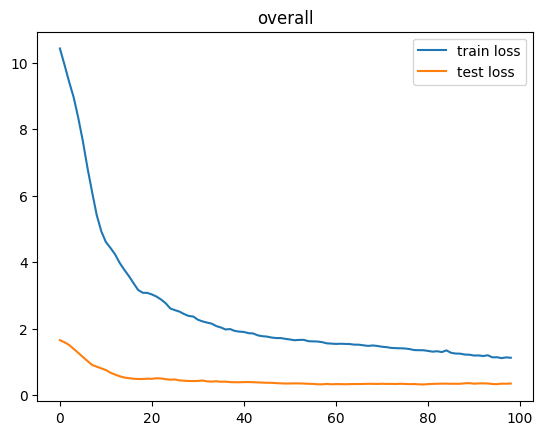

Text(0.5, 1.0, 'single')

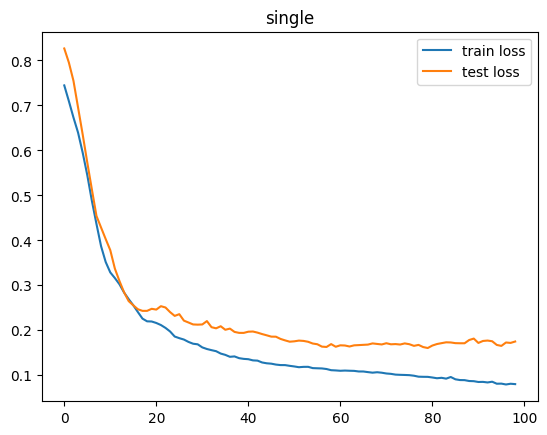

In [85]:
# training step, nearly the same with the previous IPNN training
model = IndicatorPredictNN(indicators_dim, indicators_dim, indicators_dim, 1, 1)
model.to(device)

n_epochs = 100
lr = 0.01

# criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train.shape

losses = []
test_losses = []
for epoch in range(1, n_epochs):
    optimizer.zero_grad()
    loss_total = 0

    for i in range(train.shape[0]):
        X = torch.Tensor(train[i, :LAG-1, :].reshape((1, LAG-1, 20))).to(device)
        y = torch.Tensor(train[i, LAG-1, :].reshape((1, 20))).to(device)

        out = model(X)
        loss = criterion(out, y)

        loss.backward()

        loss_total += loss.item()
    
    optimizer.step()

    loss_total_test = 0
    for i in range(test.shape[0]):

        X_test = torch.Tensor(test[i, :LAG-1, :].reshape((1, LAG-1, 20))).to(device)
        y_test = torch.Tensor(test[i, LAG-1, :].reshape((1, 20))).to(device)

        out = model(X_test)
        loss = criterion(out, y_test)

        loss_total_test += loss.item()


    losses.append(loss_total)
    test_losses.append(loss_total_test)
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss_total))


## total loss every 10 epoch
plt.plot(losses)
plt.plot(test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('overall')
plt.show()


## average loss on each sample
single_losses = np.array(losses) / train.shape[0]
single_test_losses = np.array(test_losses) / test.shape[0]

plt.plot(single_losses)
plt.plot(single_test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('single')

In [86]:
# predict next 7 years urbanization indicators
num_years = 7

length = canada_numric.shape[1]
history = canada_numric[:, -LAG+1:]
print(history.shape)
for i in range(num_years):
    X = torch.Tensor(history[:, -LAG+1:].reshape(1, LAG-1, 20)).to(device)
    pred = model(X)

    pred_np = np.concatenate(pred.cpu().detach().numpy()).reshape(20, 1)
    history = np.concatenate([history, pred_np], axis=1)

(20, 5)


In [87]:
"""_summary_
plot indicators scaled predictions and existings
"""
def plot_single(history):
    variable_names = canada['Indicator Name'].unique()
    row_len = 5
    col_len = 4

    fig, ax = plt.subplots(row_len, col_len)

    fig.set_size_inches(24, 12)
    fig.tight_layout(pad=2.0)

    for i in range(20):
        row = i // col_len
        col = i % col_len

        ax[row, col].plot(range(2017-LAG, 2017),history[i][:LAG])
        ax[row, col].plot(range(2017, 2017+num_years), history[i][LAG-1:])
        ax[row, col].title.set_text(variable_names[i][:40])
    # return fig

    

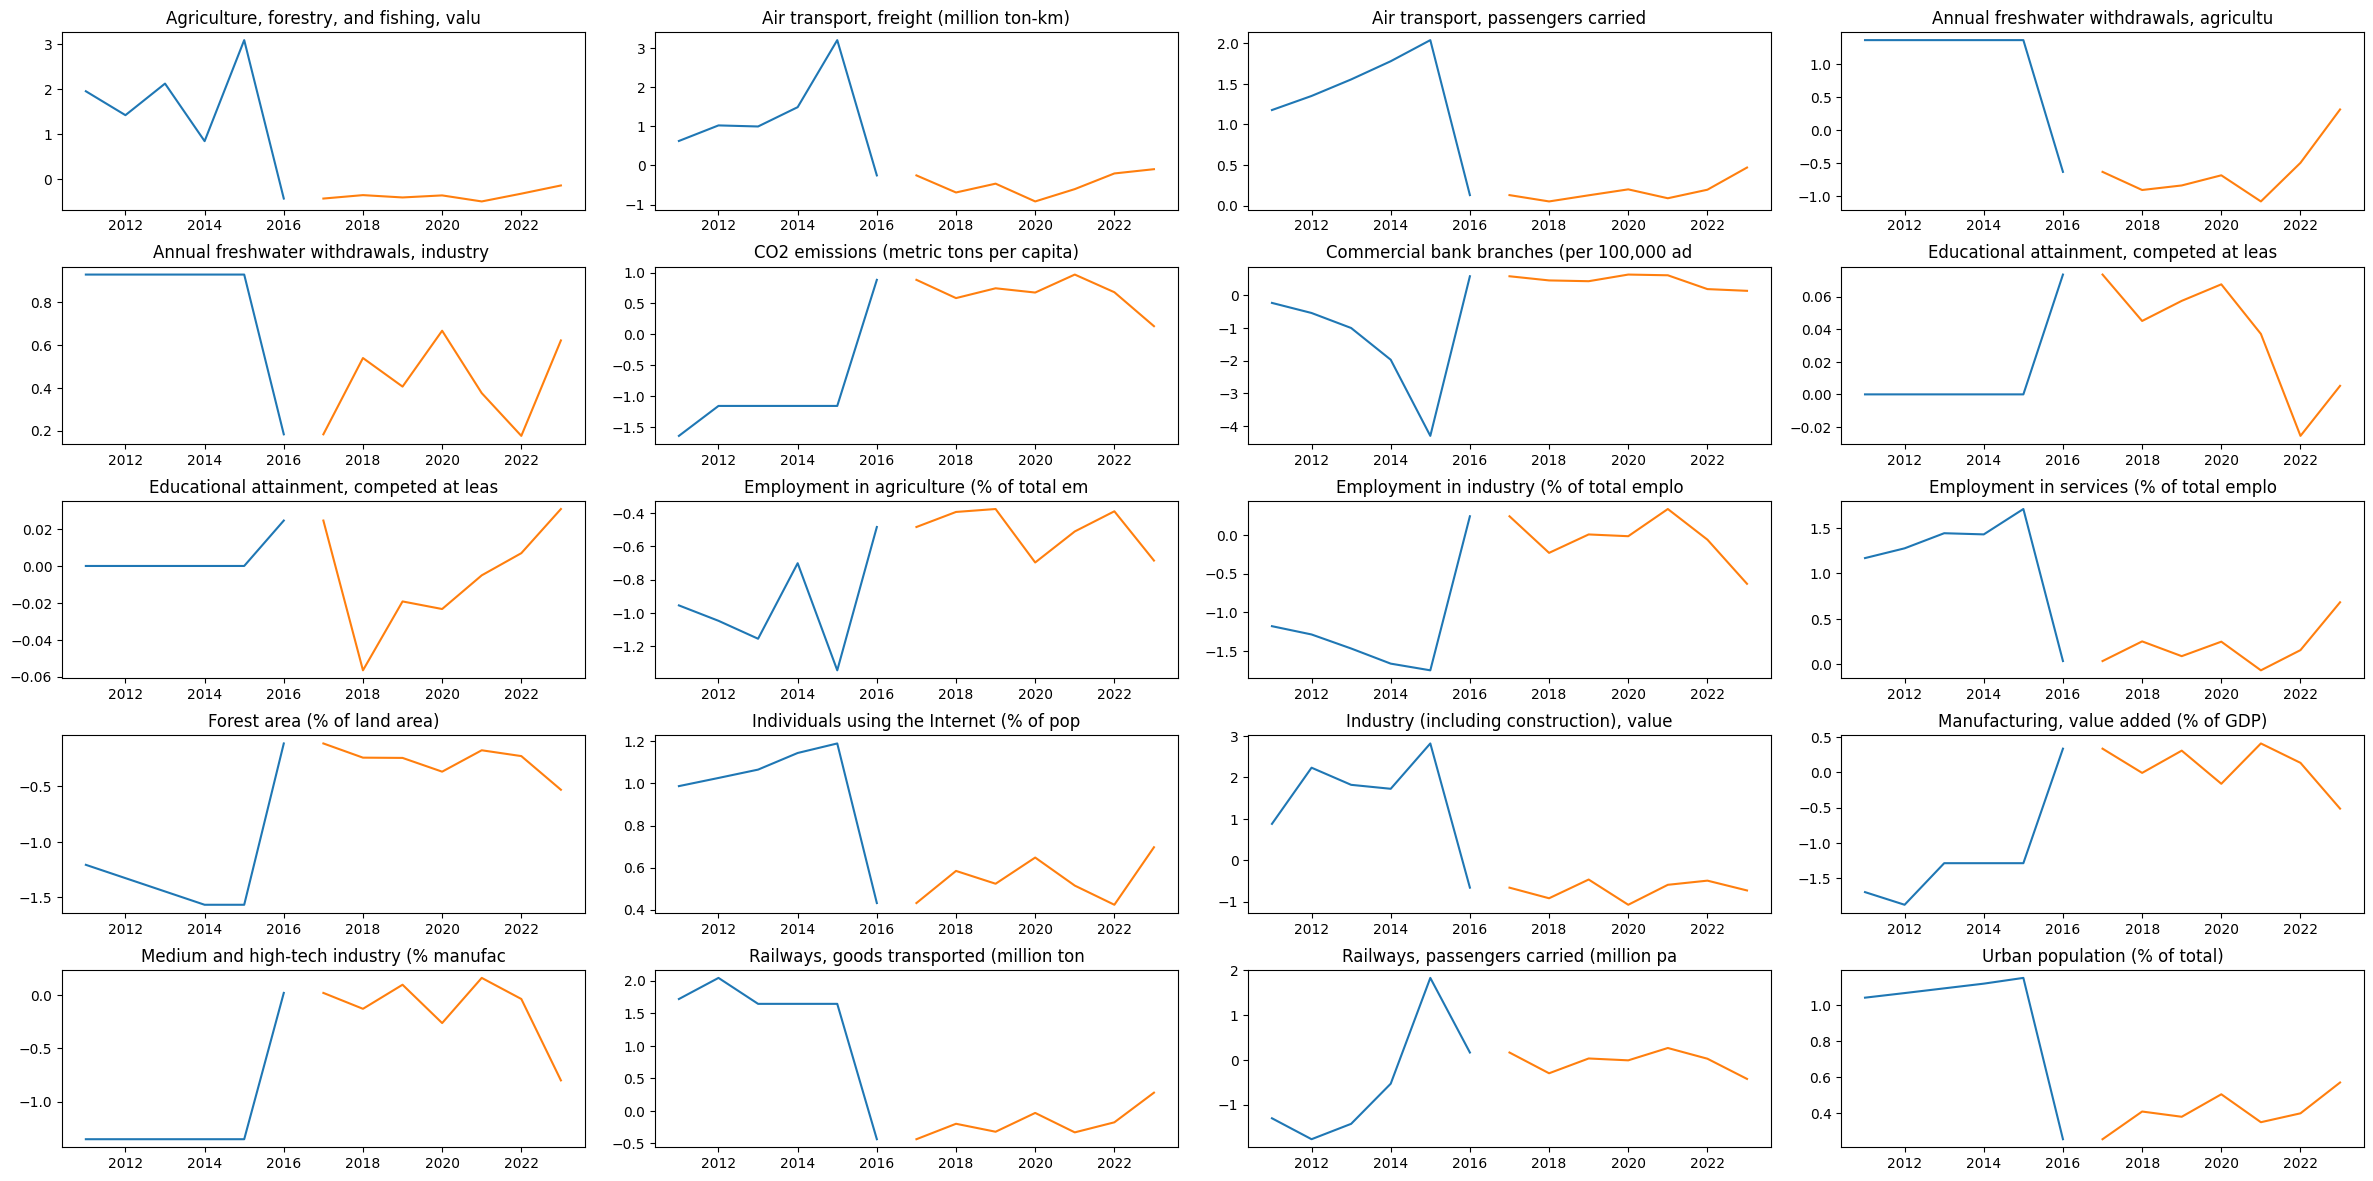

In [88]:
plot_single(history)

In [96]:
"""_summary_
plot indicators predictions and existings with normal scale
"""
def plotRescaled(history):
    history = scaler.inverse_transform(history.T).T

    variable_names = canada['Indicator Name'].unique()
    row_len = 5
    col_len = 4

    fig, ax = plt.subplots(row_len, col_len)

    fig.set_size_inches(24, 12)
    fig.tight_layout(pad=2.0)

    for i in range(20):
        row = i // col_len
        col = i % col_len

        ax[row, col].plot(range(2017-LAG, 2017),history[i][:LAG])
        ax[row, col].plot(range(2017, 2017+num_years), history[i][LAG-1:])
        ax[row, col].title.set_text(variable_names[i][:40])
    
    # return fig

    

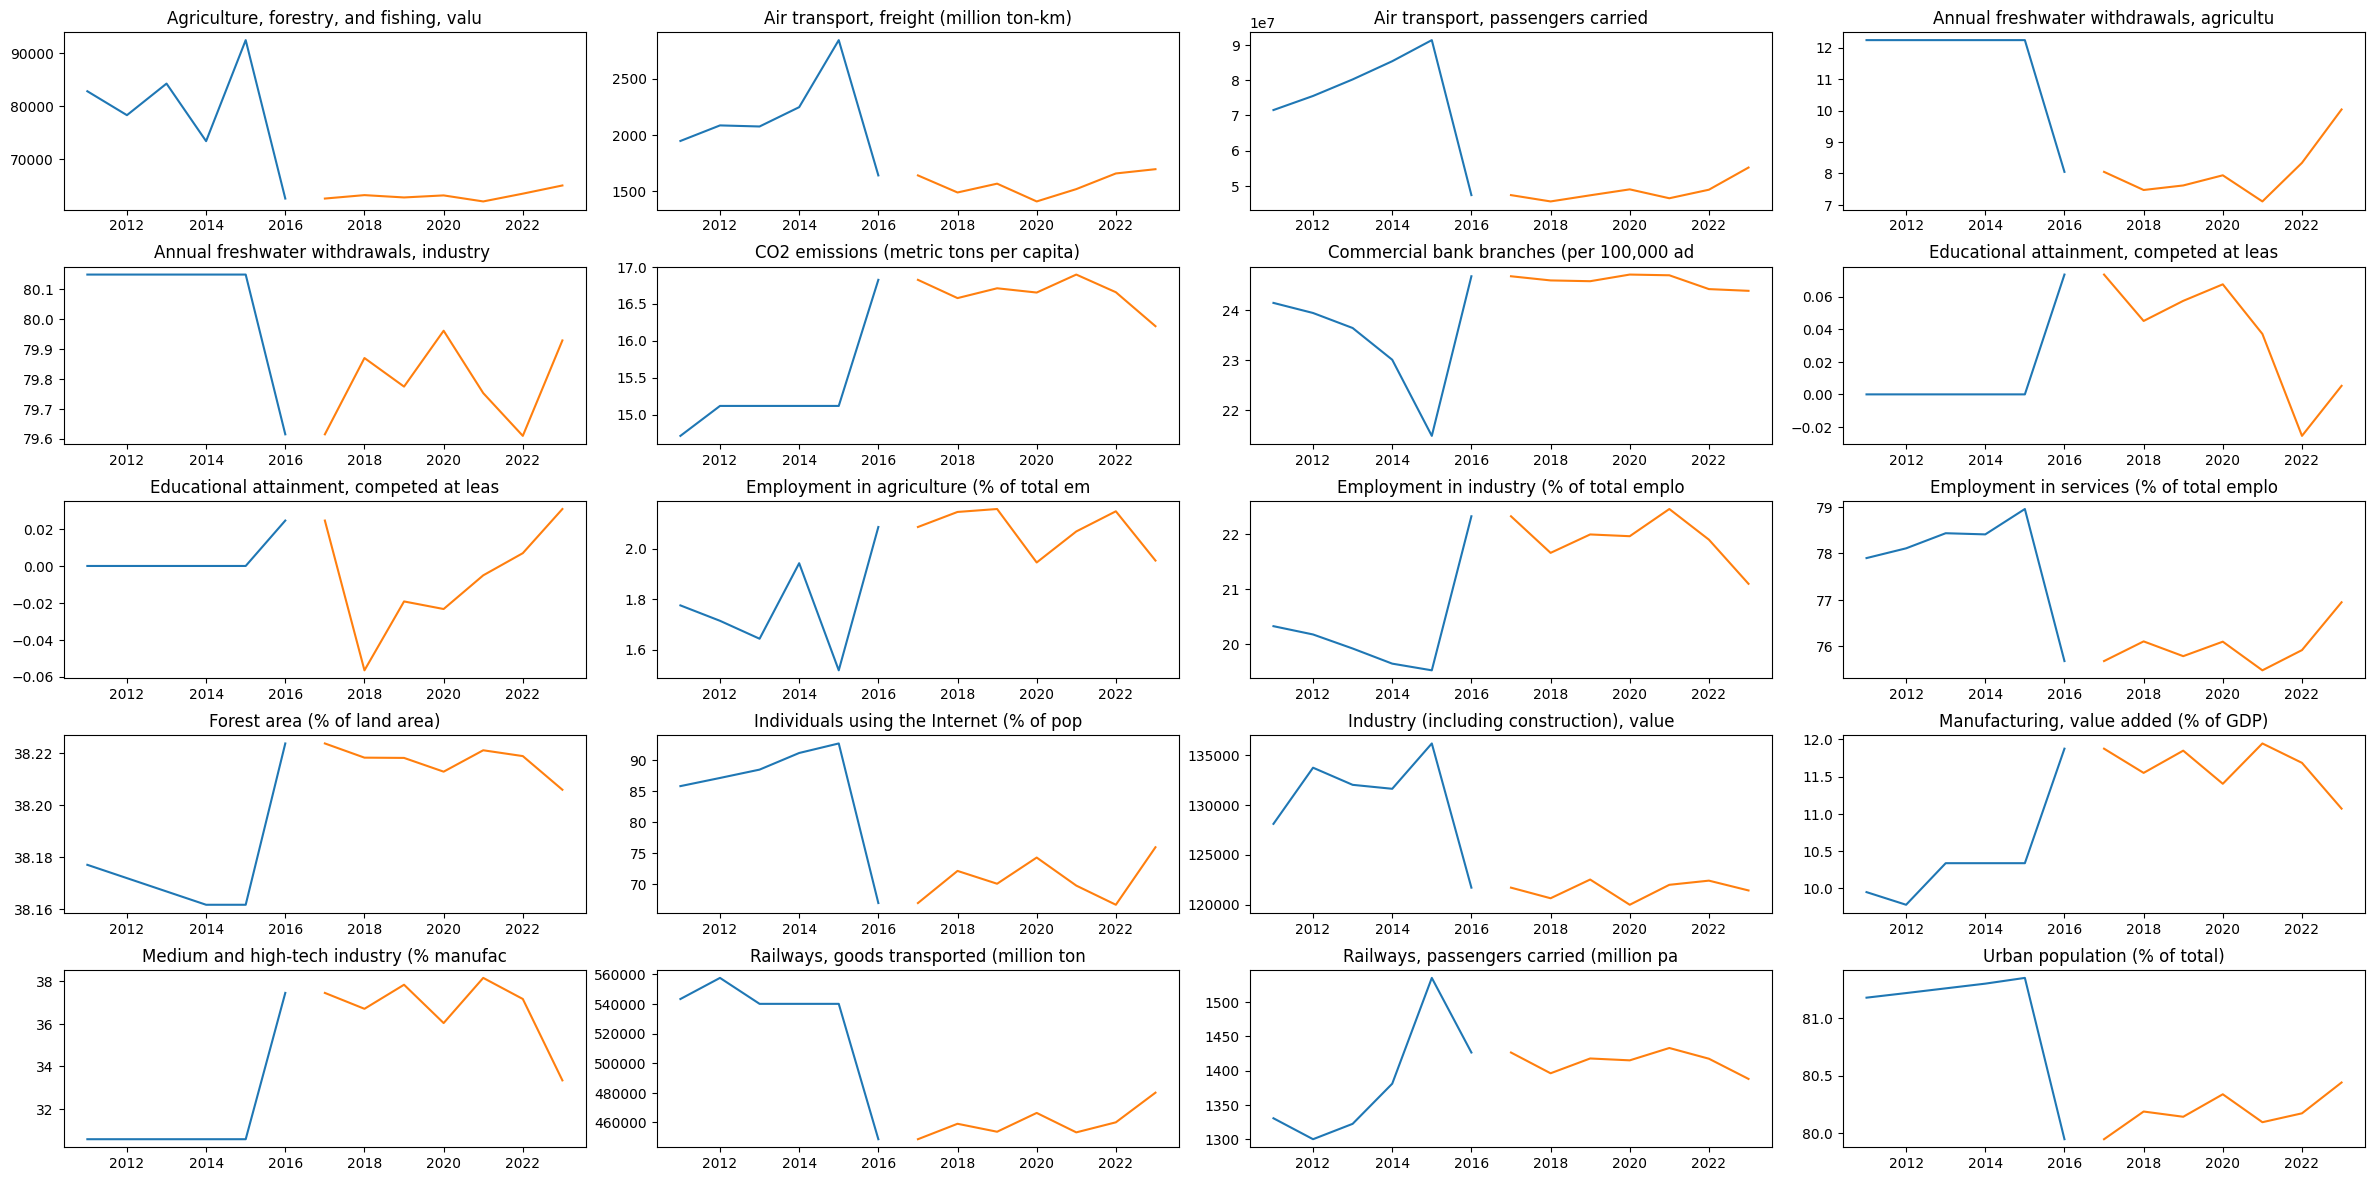

In [90]:
plotRescaled(history)

In [91]:
"""_summary_
take IPNN output as input of FPNN to predict future happiness score
"""
indicators = list(canada['Indicator Name'].unique())

index_mapping = []

for indicator in fpnn_input_columns:
    index_mapping.append(indicators.index(indicator)) 


history4score = scaler.inverse_transform(history.T).T
history4score = history4score[index_mapping]
history4score =  X_scaler.transform(history4score.T)

In [92]:
X = torch.Tensor(history4score).to(device)
preds = fpnn(X)
preds = preds.cpu().detach().numpy()
preds = Y_scaler.inverse_transform(preds)
preds.shape

(12, 7)

In [93]:
scoreFrom2017 = getHappinessScore(preds)
scoreFrom2017 = scoreFrom2017.reshape(scoreFrom2017.shape[0])[-num_years:]

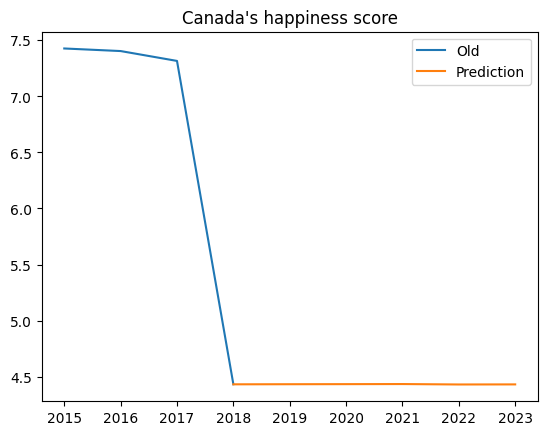

In [94]:
# scoreBefore2017 = 
scoreBefore2017 = wh_df[wh_df['Country'] == Country]['Happiness score'].iloc[:3].to_numpy()
scoreBefore2017

plt.plot(range(2015, 2019), np.concatenate([scoreBefore2017, [scoreFrom2017[0]]]))
plt.plot(range(2018, 2017+num_years), scoreFrom2017[1:])
plt.title(f'{Country}\'s happiness score')
plt.legend(['Old', 'Prediction'])

# Appendix: ARMAV

The following cells demonstrate the issues that were encountered while attempting to use the ARMAV model to predict the future values of urbanization indicators and happiness scores.

In [95]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# Using the custom imputation method defined in the "impute_row" function
df_history = sgd_imputed.iloc[:, 4:]
df_history

# This will not work, because a positive definite matrix is required
mod = sm.tsa.VARMAX(df_history.iloc[:20, :], order=(1,1))
res = mod.fit(maxiter=1000, disp=False)

/home/chan/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/chan/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'


LinAlgError: Matrix is not positive definite

In [ ]:
# Using linear interpolation
armav_ins = sgd_urban.interpolate().iloc[:, 4:].dropna()
armav_ins

# This takes much longer to execute, and will eventually yield a Schur decomposition solver error
mod = sm.tsa.VARMAX(armav_ins, order=(1,1))
res = mod.fit(maxiter=1000, disp=False)

c:\Users\rekak\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\rekak\anaconda3\envs\test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\rekak\anaconda3\envs\test\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


KeyboardInterrupt: 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
data = np.zeros(10)
model = ARIMA(data, order=(2, 0, 0)).fit()
model.summary()

c:\Users\rekak\anaconda3\envs\test\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\rekak\anaconda3\envs\test\lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
c:\Users\rekak\anaconda3\envs\test\lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 106.380
Date:                Fri, 16 Dec 2022   AIC                           -204.759
Time:                        20:23:12   BIC                           -203.549
Sample:                             0   HQIC                          -206.087
                                 - 10                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.825e-06   5.16e-13  -9.36e+06      0.000   -4.82e-06   -4.82e-06
ar.L1       4.823e-17   2.24e-18     21.540      0.000    4.38e-17    5.26e-17
ar.L2        9.65e-17   1.99e-18     48.481      0.000    9.26e-17       1e-16
sigma2      1.097e-11   6.09e-10      0.018      0.986   -1.18e-09     1.2e-09
===================================================================================
Ljung-Box (L1) (Q):                   6.53   Jarque-Bera (JB):                  nan
Prob(Q):                              0.01   Prob(JB):                          nan
Heteroskedasticity (H):               1.00   Skew:                              nan
Prob(H) (two-sided):                  1.00   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+33. Standard errors may be unstable.
"""

In [ ]:
model.predict()

array([-4.82455817e-06, -4.82455817e-06, -4.82455817e-06, -4.82455817e-06,
       -4.82455817e-06, -4.82455817e-06, -4.82455817e-06, -4.82455817e-06,
       -4.82455817e-06, -4.82455817e-06])